In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.model_selection import cross_validate

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split


## Data Preparation

In [2]:
# I would like to see all the columns and rows for this dataset 
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', None)

In [3]:
# Here is the dispaly of the training set 
df_train = pd.read_parquet('F:/United States/University of Southern California/Semester 2/Data Mining/Final/navigating-financial-instability/20231124_Financial_Risk_Project_train (1).parquet')
df_train.head()

url  \
ticker                                                      
FICO    https://seekingalpha.com/article/4649507-fair-...   
RXRX    https://seekingalpha.com/earnings/earnings-cal...   
BLDR    https://seekingalpha.com/article/4645938-build...   
JKHY    https://seekingalpha.com/article/4649242-jack-...   
OC      https://seekingalpha.com/article/4643409-owens...   

                                          call_transcript    VWAP  \
ticker                                                              
FICO    Fair Isaac Corporation (FICO) Q4 2023 Earnings...  700.83   
RXRX    Earnings Call Transcripts | Seeking Alpha\n\n\...    6.67   
BLDR    Builders FirstSource, Inc. (BLDR) Q3 2023 Earn...   88.34   
JKHY    Jack Henry & Associates, Inc. (JKHY) Q1 2024 E...  150.47   
OC      Owens Corning (OC) Q3 2023 Earnings Call Trans...   95.47   

       exchangeCountry        securityType         CIK  \
ticker                                                   
FICO               USA  Common or ordinary  0000814547   
RXRX               USA  Common or ordinary  0001601830   
BLDR               USA  Common or ordinary  0001316835   
JKHY               USA  Common or ordinary  0000779152   
OC                 USA  Common or ordinary  0001370946   

                                  name  securityID incorporationCountry  \
ticker                                                                    
FICO            Fair Isaac Corporation   138240101                  USA   
RXRX    Recursion Pharmaceauticals Inc   384740101                  USA   
BLDR          Builders FirstSource Inc  1630360101                  USA   
JKHY     Henry (Jack) & Associates Inc   118110101                  USA   
OC                       Owens Corning    82140601                  USA   

                   exchangeName exchangeID  Accrual Ratio      Assets  \
ticker                                                                  
FICO    New York Stock Exchange          N      -0.057303   57.331800   
RXRX        Nasdaq Stock Market          T      -0.184047    3.777067   
BLDR    New York Stock Exchange          N      -0.054418   72.174114   
JKHY        Nasdaq Stock Market          T      -0.044987   35.249330   
OC      New York Stock Exchange          N      -0.008413  114.140127   

             B/P      CF/P  Capital Expenditure       Cash  Debt/Equity  \
ticker                                                                    
FICO   -0.052667  0.030849             0.230295   5.496836          NaN   
RXRX    0.339365 -0.059654             0.211722   2.968665     0.104990   
BLDR    0.521038  0.350345             2.150370   0.547990     0.703148   
JKHY    0.117668  0.038808             0.405746   0.352223     0.213858   
OC      0.569366  0.213668             4.589211  11.751592     0.704918   

        Depreciation  Dividend       E/P       EBIT    EBIT/P  EBIT/TEV  \
ticker                                                                    
FICO        0.754974  0.000000  0.024975  26.427041  0.044150  0.039410   
RXRX        0.066933  0.000000 -0.177278  -1.318327 -0.170989 -0.262822   
BLDR        3.078584  0.000000  0.256665  31.302514  0.482468  0.355299   
JKHY        2.501891  1.953958  0.027464  10.288698  0.058605  0.057279   
OC          5.183119  1.395167  0.148610  26.972104  0.316203  0.249113   

         Earnings  Earnings Growth (1Y)  Earnings Growth (2Y)  \
ticker                                                          
FICO    14.949789              0.099608              0.290012   
RXRX    -1.366812                   NaN                   NaN   
BLDR    16.652426              0.957564              1.504925   
JKHY     4.821647              0.035173              0.113103   
OC      12.676423              0.328732                   NaN   

        Earnings Growth (3Y)  Earnings Growth (4Y)  Earnings Growth (5Y)  \
ticker                                                                     
FICO                0.297537         

In [4]:
# check the data type and missing value of each variable
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, FICO to GBCI
Data columns (total 73 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   url                                   415 non-null    object 
 1   call_transcript                       415 non-null    object 
 2   VWAP                                  415 non-null    float64
 3   exchangeCountry                       415 non-null    object 
 4   securityType                          415 non-null    object 
 5   CIK                                   415 non-null    object 
 6   name                                  415 non-null    object 
 7   securityID                            415 non-null    int64  
 8   incorporationCountry                  415 non-null    object 
 9   exchangeName                          415 non-null    object 
 10  exchangeID                            412 non-null    object 
 11  Accrual Ratio       

In [5]:
# We can drop this column since there is no difference in this variable for the data set 
print(df_train['exchangeCountry'].value_counts())

exchangeCountry
USA    415
Name: count, dtype: int64


In [6]:
# Drop this column since only 2 cases have the same "CIK", and we can regard it as an unique value
print(df_train['CIK'].nunique())
print(df_train['CIK'].value_counts())

414
CIK
0001652044    2
0000814547    1
0000731766    1
0000106040    1
0001472787    1
0001219601    1
0000027904    1
0001137774    1
0000012927    1
0000920522    1
0000060086    1
0001124198    1
0000874766    1
0001467373    1
0001609711    1
0001069202    1
0000085535    1
0000018349    1
0001002047    1
0001397187    1
0000042888    1
0000077476    1
0000726958    1
0001331520    1
0001745999    1
0000916540    1
0001069157    1
0000107263    1
0001120193    1
0000794170    1
0001302215    1
0001283699    1
0000829224    1
0001591698    1
0001539838    1
0000895417    1
0001262039    1
0000708955    1
0000920760    1
0001822993    1
0001099590    1
0001059556    1
0001596967    1
0000002488    1
0001674416    1
0001095073    1
0000896159    1
0001682852    1
0001132979    1
0001512673    1
0000063908    1
0001852244    1
0000064040    1
0001069183    1
0001288784    1
0000020212    1
0000097745    1
0000712537    1
0001045810    1
0001534701    1
0001858681    1
0001669811    1


In [7]:
# Drop this column for the same reason as before 
print(df_train['securityID'].nunique())

415


In [8]:
# For these two columns, they refer to the same thing. Therefore, the exchangeName column will be dropped
#     and we keep exchangeID. But we should be aware that there are 3 missing values.
print(df_train['exchangeName'].value_counts())
print(df_train['exchangeID'].value_counts())

exchangeName
New York Stock Exchange    255
Nasdaq Stock Market        156
Other-OTC                    3
Cboe BZX Exchange            1
Name: count, dtype: int64
exchangeID
N    255
T    156
Z      1
Name: count, dtype: int64


In [9]:
# We see the values are mostly "20221231", drop this column 
df_train['fiscalDint'].value_counts()

fiscalDint
20221231    369
20221031     16
20221130     11
20221030      5
20221230      3
20221029      2
20230101      2
20221201      1
20221119      1
20221229      1
20221105      1
20221028      1
20221202      1
20221225      1
Name: count, dtype: int64

In [10]:
# We can see that the number of 0's in FinancialSector is equal to 0's in FinancialRisk, which are zero-risk companies
# and we only care the classification of 0 or 1 in FinancialSector, not the specific risk scores.
# Therefore, we can drop the FinancialRisk column
print(df_train['FinancialSector'].value_counts())
print(df_train['FinancialRisk'].value_counts())

FinancialSector
0    268
1    147
Name: count, dtype: int64
FinancialRisk
 0.000000    268
 0.196409      1
 0.052267      1
-0.014358      1
 0.094662      1
 0.228666      1
 0.094053      1
 0.055664      1
 0.155800      1
-0.030820      1
 0.253932      1
 0.883164      1
 0.064089      1
 0.061833      1
 0.103754      1
-0.054006      1
 0.091810      1
 0.014759      1
 0.031901      1
 0.074036      1
 0.042736      1
 0.153743      1
 0.128684      1
 0.108932      1
 0.217855      1
 0.073428      1
 0.495940      1
 0.998330      1
 0.263158      1
 0.010893      1
 0.127383      1
 0.212294      1
 0.178034      1
 0.017412      1
-0.044733      1
 0.120406      1
 0.019974      1
 0.107055      1
 0.077207      1
 0.267601      1
 0.169960      1
 0.099188      1
 0.111193      1
 0.090731      1
 0.112630      1
-0.033164      1
 0.047962      1
 0.015488      1
 0.173200      1
 0.029467      1
 0.199057      1
-0.028785      1
 0.216483      1
-0.081966      1
 0.64345

The ratio of 0 and 1 is less than 2:1, a ratio might or might not affect positive learning cost, so for now we ignore this imbalance.

Up to now, the first problem is that some categorical variables are extremely imbalanced, such as 'securityType' and 'incorporationCountry'. So we want to look at this case more specificly. 

In [11]:
# Now we check securityType 
print(df_train['securityType'].value_counts())

securityType
Common or ordinary                   414
American Depository Receipt (ADR)      1
Name: count, dtype: int64


In [12]:
# We notice there is one special case and we want to look at it deeper. We see the incorporationCountry is "GBR".
df_train[df_train['securityType'] == 'American Depository Receipt (ADR)']

url  \
ticker                                                      
CMPS    https://seekingalpha.com/article/4647616-compa...   

                                          call_transcript   VWAP  \
ticker                                                             
CMPS    COMPASS Pathways plc (CMPS) Q3 2023 Earnings C...  10.28   

       exchangeCountry                       securityType         CIK  \
ticker                                                                  
CMPS               USA  American Depository Receipt (ADR)  0001816590   

                        name  securityID incorporationCountry  \
ticker                                                          
CMPS    COMPASS Pathways plc   369759001                  GBR   

               exchangeName exchangeID  Accrual Ratio    Assets       B/P  \
ticker                                                                      
CMPS    Nasdaq Stock Market          T        0.07381  4.649213  0.531903   

            CF/P  Capital Expenditure      Cash  Debt/Equity  Depreciation  \
ticker                                                                       
CMPS   -0.309935             0.014054  3.378759     0.010637      0.007782   

        Dividend      E/P     EBIT    EBIT/P  EBIT/TEV  Earnings  \
ticker                                                             
CMPS         0.0 -0.26895 -2.24772 -0.279915  -0.47851  -2.15967   

        Earnings Growth (1Y)  Earnings Growth (2Y)  Earnings Growth (3Y)  \
ticker                                                                     
CMPS                     NaN                   NaN                   NaN   

        Earnings Growth (4Y)  Earnings Growth (5Y)  Earnings Variability  \
ticker                                                                     
CMPS                     NaN                   NaN                   NaN   

          Equity      FCF     FCF/P  Income Tax  Interest Expense  \
ticker                                                              
CMPS    4.271185 -2.50283 -0.311685    0.009639               0.0   

        Long Liabilities  Long Term Debt    Market Cap  Minority Interest  \
ticker                                                                      
CMPS            0.377368         0.00985  3.417117e+08                0.0   

        Operating Cash Flow  Operating Expense  Operating Income  \
ticker                                                             
CMPS              -2.488776           2.257359         -2.265141   

        Operating Income Before Depreciation  Operating Margin  \
ticker                                                           
CMPS                               -2.257359               NaN   

        Preferred Stock  Profit Margin       R&D  R&D/Sales       ROA  \
ticker                                                                  
CMPS            0.00066            NaN  1.535362        NaN -0.464524   

             ROE  S/P      SG&A  SG&A/Sales  Sales  Sales Growth (1Y)  \
ticker                                                                  
CMPS   -0.505637  0.0  2.257359         NaN    0.0                NaN   

        Sales Growth (2Y)  Sales Growth (3Y)  Sales Growth (4Y)  \
ticker                                                            
CMPS                  NaN                NaN                NaN   

        Sales Growth (5Y)  Sales Variability  Short Term Debt       TEV  \
ticker                                                                    
CMPS                  NaN                NaN         0.035583  4.697334   

        Working Capital                                businessDescription  \
ticker                                                                       
CMPS           4.148718  COMPASS Pathways plc operates as a mental heal...   

        close  dividendFactor  fiscalDint  floatShares  outstandingShares  \
ticker                                                                      
CMPS     8.03     

In [13]:
# Expore further. We find the majority of incorporationCountry is "USA", 
# so we name all the other values in "otherCountries" category. 
print(df_train['incorporationCountry'].value_counts())

incorporationCountry
USA    400
BMU      5
GBR      4
IRL      2
CHE      2
CAN      1
URY      1
Name: count, dtype: int64


Summary:
The incorporationCountry of this case is "GBR", and there are only 4 "GBR"'s, which are minorities. Compared to "USA", the number of other countires is relatively small and impacts little to the model. Therefore, it is better to lump up all the other countires as a category variable, called "otherCountries". By doing so, "securityType" can be dropped.


In [14]:
df_train.loc[df_train['incorporationCountry'] != 'USA', 'incorporationCountry' ] = 'otherCountries'
print(df_train['incorporationCountry'].value_counts()) 

incorporationCountry
USA               400
otherCountries     15
Name: count, dtype: int64


Since we do not want to involved in NLP analysis, we can also drop "call_transcript" and "businessDescription"

Drop all useless columns:url,exchangeCountry,securityType,CIK,name,securityID,exchangeName,FinancialRisk,FiscalDint,call_transcript and businessDescription. 


In [15]:
df_train.drop(['url', 'exchangeCountry', 'securityType', 'CIK', 'name', 'securityID', 'exchangeName', 'FinancialRisk','call_transcript','businessDescription','fiscalDint'], axis =1, inplace = True)
df_train.head()

VWAP incorporationCountry exchangeID  Accrual Ratio      Assets  \
ticker                                                                      
FICO    700.83                  USA          N      -0.057303   57.331800   
RXRX      6.67                  USA          T      -0.184047    3.777067   
BLDR     88.34                  USA          N      -0.054418   72.174114   
JKHY    150.47                  USA          T      -0.044987   35.249330   
OC       95.47                  USA          N      -0.008413  114.140127   

             B/P      CF/P  Capital Expenditure       Cash  Debt/Equity  \
ticker                                                                    
FICO   -0.052667  0.030849             0.230295   5.496836          NaN   
RXRX    0.339365 -0.059654             0.211722   2.968665     0.104990   
BLDR    0.521038  0.350345             2.150370   0.547990     0.703148   
JKHY    0.117668  0.038808             0.405746   0.352223     0.213858   
OC      0.569366  0.213668             4.589211  11.751592     0.704918   

        Depreciation  Dividend       E/P       EBIT    EBIT/P  EBIT/TEV  \
ticker                                                                    
FICO        0.754974  0.000000  0.024975  26.427041  0.044150  0.039410   
RXRX        0.066933  0.000000 -0.177278  -1.318327 -0.170989 -0.262822   
BLDR        3.078584  0.000000  0.256665  31.302514  0.482468  0.355299   
JKHY        2.501891  1.953958  0.027464  10.288698  0.058605  0.057279   
OC          5.183119  1.395167  0.148610  26.972104  0.316203  0.249113   

         Earnings  Earnings Growth (1Y)  Earnings Growth (2Y)  \
ticker                                                          
FICO    14.949789              0.099608              0.290012   
RXRX    -1.366812                   NaN                   NaN   
BLDR    16.652426              0.957564              1.504925   
JKHY     4.821647              0.035173              0.113103   
OC      12.676423              0.328732                   NaN   

        Earnings Growth (3Y)  Earnings Growth (4Y)  Earnings Growth (5Y)  \
ticker                                                                     
FICO                0.297537              0.362822              0.311360   
RXRX                     NaN                   NaN                   NaN   
BLDR                1.063553              0.753627              1.193886   
JKHY                0.096844              0.066825              0.012147   
OC                  0.509436              0.268301              0.377587   

        Earnings Variability     Equity        FCF     FCF/P  Income Tax  \
ticker                                                                     
FICO                0.307516 -31.525174  18.235074  0.030464    3.795300   
RXRX                     NaN   2.616502  -0.671652 -0.087114    0.000000   
BLDR                0.752212  33.804946  20.580009  0.317201    4.974752   
JKHY                0.174350  20.657744   6.407412  0.036497    1.446616   
OC                  2.126174  48.566879  13.636695  0.159867    3.801580   

        Interest Expense  Long Liabilities  Long Term Debt    Market Cap  \
ticker                                                                     
FICO            3.086197         88.856974       72.832056  1.505668e+10   
RXRX            0.000314          1.160564        0.242129  1.342102e+09   
BLDR            1.052159         38.369169       23.040225  9.666731e+09   
JKHY            0.091219         14.591586        4.277453  1.280012e+10   
OC              1.118655         65.084926       33.375796  8.077910e+09   

        Minority Interest  Operating Cash Flow  Operating Expense  \
ticker                                                              
FICO             0.000000            18.465370          31.570363   
RXRX             0.000000            -0.459930           1.543668   
BLDR             0.000000            22.730379         112.188490   
JKHY             0

## EDA

In [16]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 415 entries, FICO to GBCI
Data columns (total 62 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   VWAP                                  415 non-null    float64
 1   incorporationCountry                  415 non-null    object 
 2   exchangeID                            412 non-null    object 
 3   Accrual Ratio                         415 non-null    float64
 4   Assets                                415 non-null    float64
 5   B/P                                   415 non-null    float64
 6   CF/P                                  415 non-null    float64
 7   Capital Expenditure                   415 non-null    float64
 8   Cash                                  415 non-null    float64
 9   Debt/Equity                           397 non-null    float64
 10  Depreciation                          415 non-null    float64
 11  Dividend            

### Categorical Variable

<Axes: xlabel='incorporationCountry', ylabel='FinancialSector'>

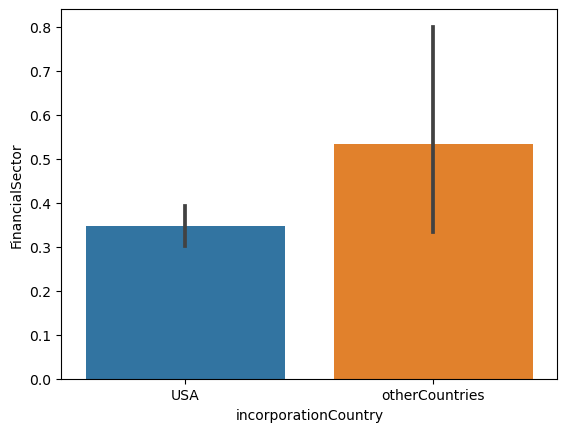

In [17]:
sns.barplot(x = 'incorporationCountry', y = 'FinancialSector', data = df_train)

From the plot, the risk of other countries is slightly larger than the risk of USA.

<Axes: xlabel='exchangeID', ylabel='FinancialSector'>

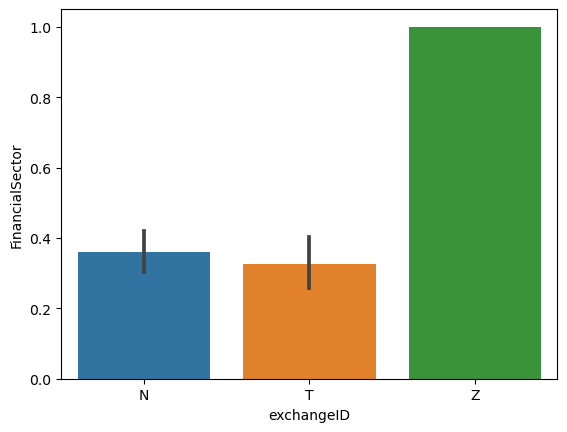

In [18]:
sns.barplot(x = 'exchangeID', y = 'FinancialSector', data = df_train)

There are little differences for different values of 'exchangeID'. Also, the rare category is expensive to encoding. So we drop this column.

### Numerical Variable

In [19]:
# Check for numerical features
df_train.describe().style.set_sticky()

In [20]:
# There are too many numerical variables. So we seperate them into two groups, 'facts' and 'ratios'.
facts = [
       'Assets', 'Capital Expenditure', 'Cash',
       'Depreciation', 'Dividend', 'Earnings', 'Equity', 'FCF', 'Income Tax',
       'Interest Expense', 'Long Liabilities', 'Long Term Debt', 'Market Cap',
       'Minority Interest', 'Operating Cash Flow', 'Operating Expense',
       'Operating Income', 'Operating Income Before Depreciation',
       'Operating Margin', 'Preferred Stock', 'Profit Margin', 'R&D',
       'R&D/Sales', 'Sales',
       'Short Term Debt', 'TEV', 'Working Capital',
       'close', 'dividendFactor', 'floatShares', 'outstandingShares',
       'shortInterestFloat'
       ]
ratios = [
        'VWAP', 'Accrual Ratio', 'B/P', 'CF/P', 'Debt/Equity', 'E/P', 'EBIT', 'EBIT/P',
        'EBIT/TEV', 'Earnings Growth (1Y)', 'Earnings Growth (2Y)',
        'Earnings Growth (3Y)', 'Earnings Growth (4Y)', 'Earnings Growth (5Y)',
        'Earnings Variability', 'FCF/P', 'ROA', 'ROE', 'S/P', 'SG&A', 'SG&A/Sales',  'Sales Growth (1Y)', 'Sales Growth (2Y)', 'Sales Growth (3Y)',
        'Sales Growth (4Y)', 'Sales Growth (5Y)', 'Sales Variability'
        ]
label = 'FinancialSector'

#### 1. Outliers

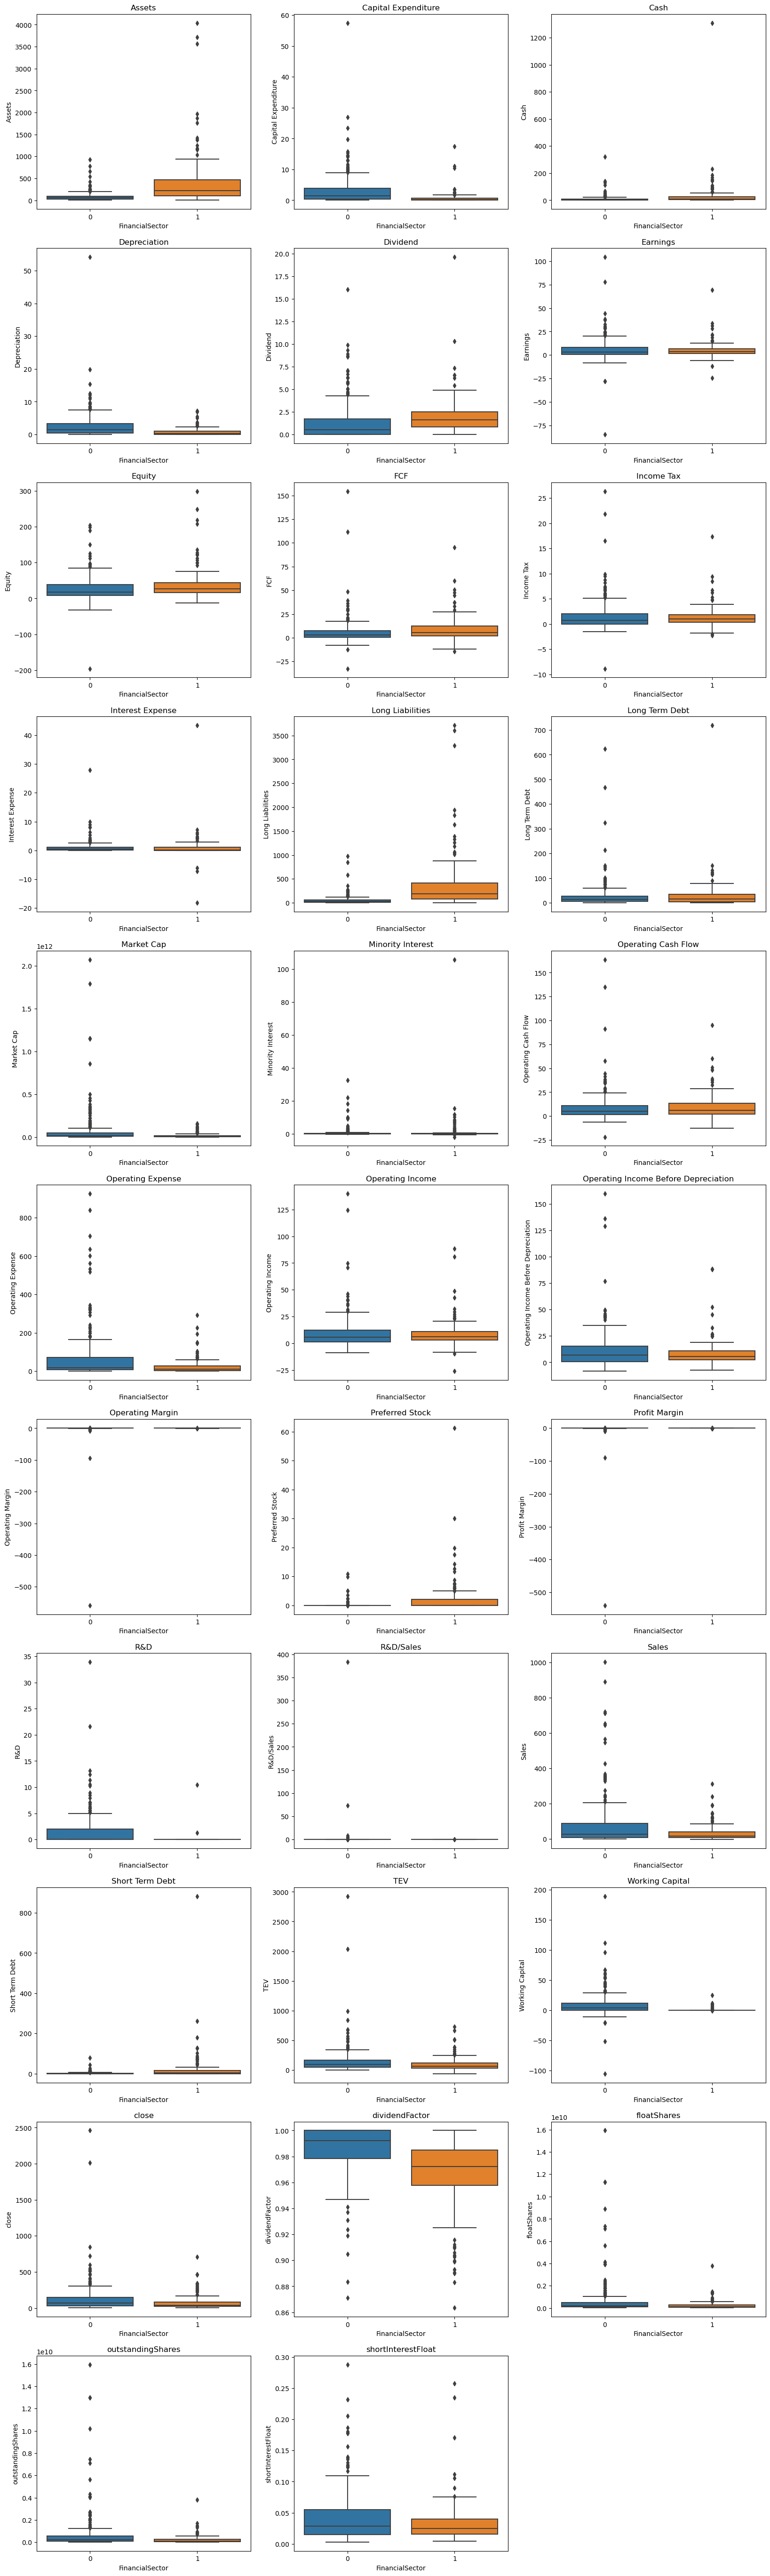

In [21]:
f = plt.figure(figsize = [20, 70])
for i in range(len(facts)):
    f.add_subplot(11, 3, i+1)
    sns.boxplot(y = facts[i], x = 'FinancialSector', data = df_train).set_title(facts[i])
plt.show()

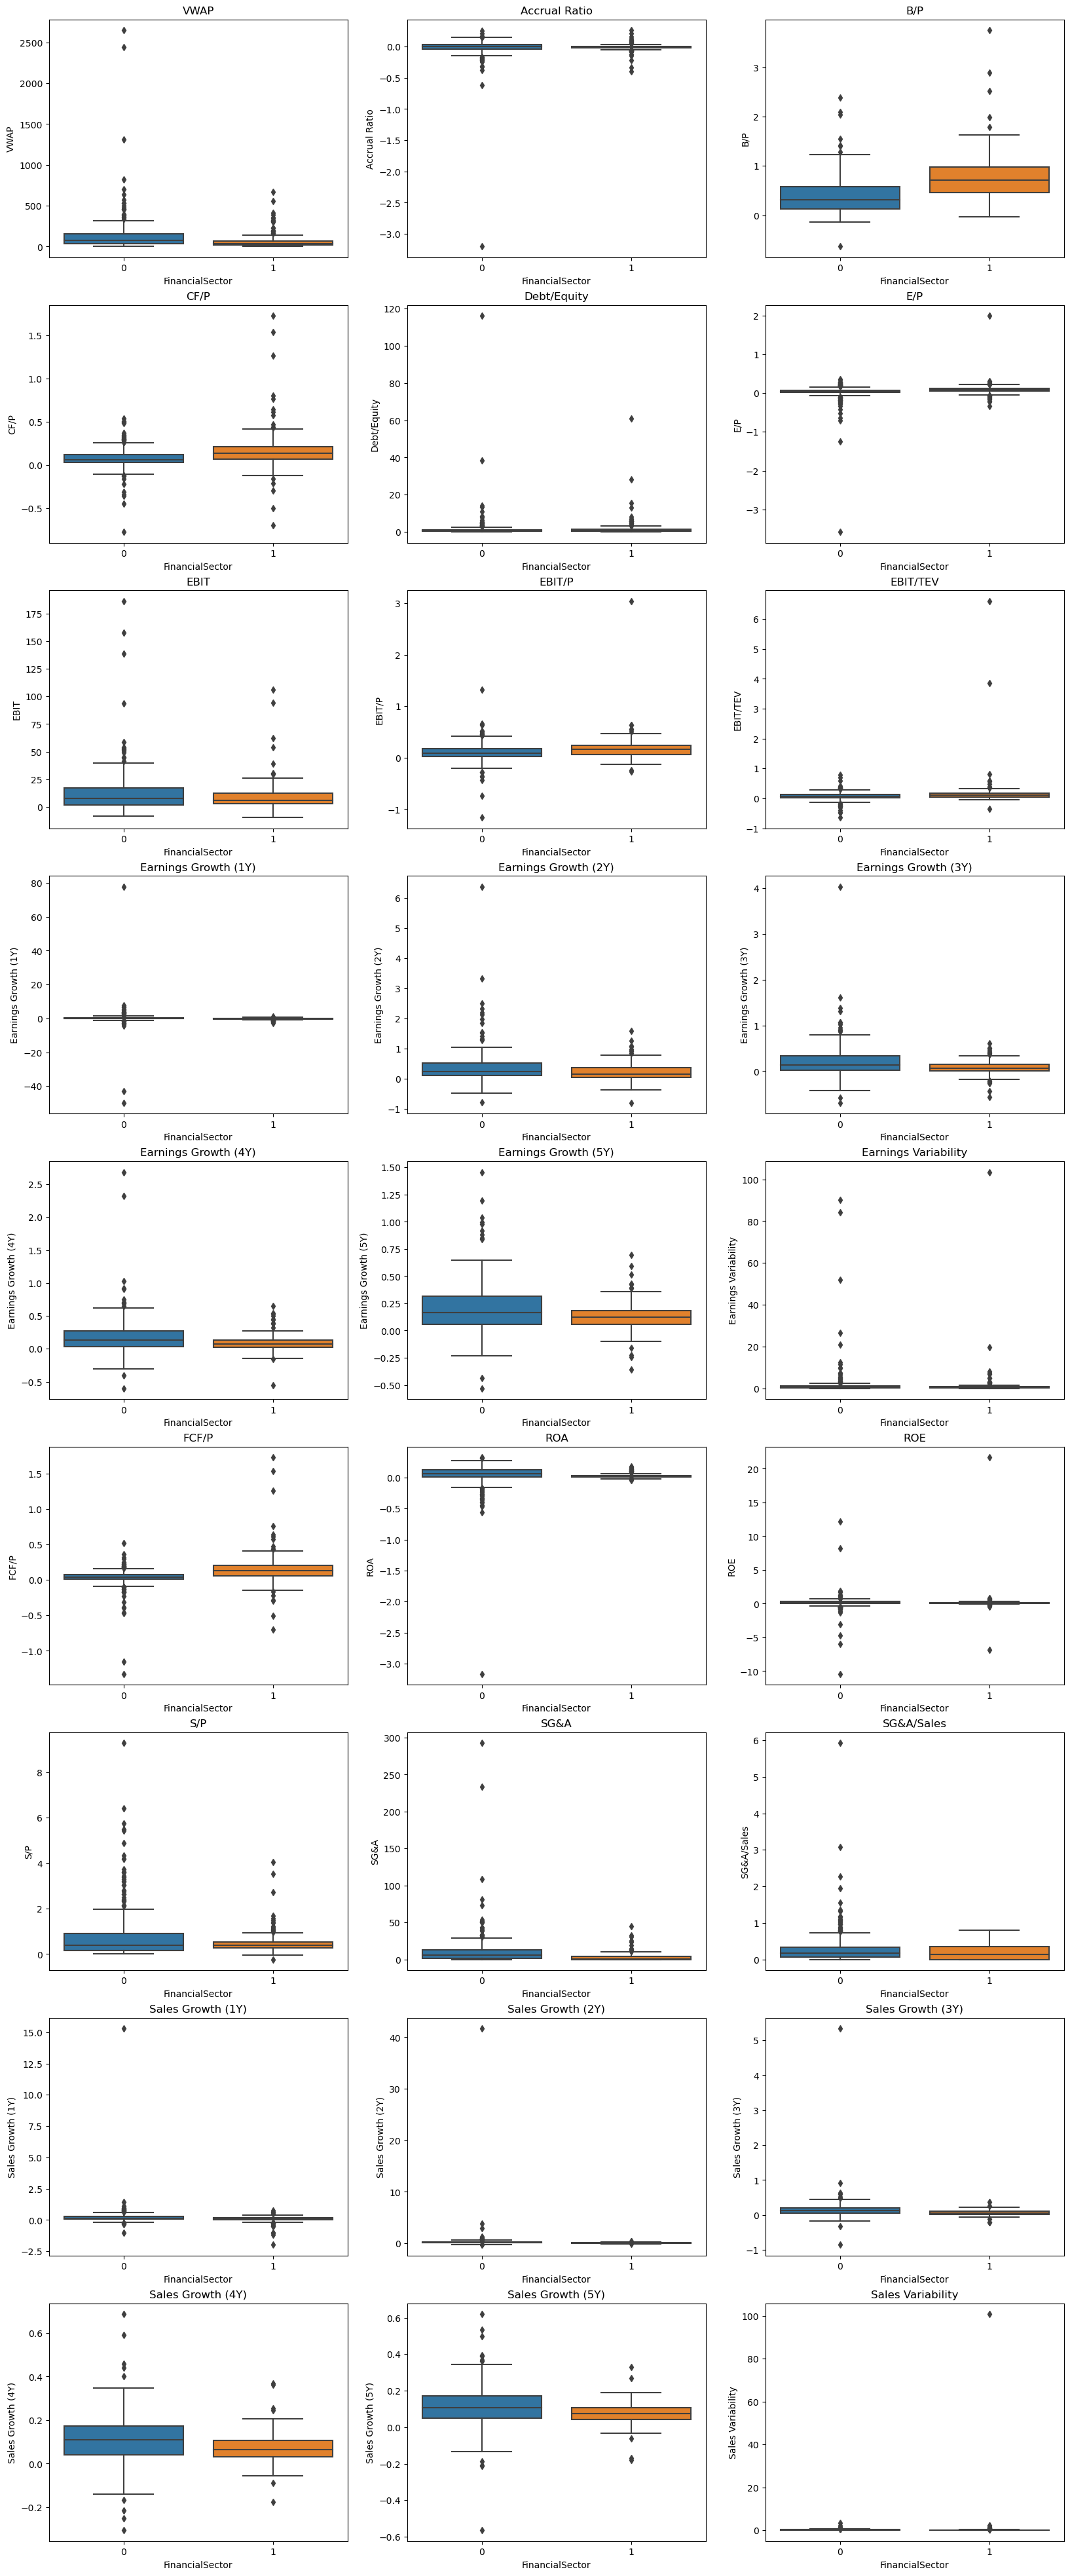

In [22]:
f = plt.figure(figsize = [20, 50])
for i in range(len(ratios)):
    f.add_subplot(9, 3, i+1)
    sns.boxplot(y = ratios[i], x = 'FinancialSector', data = df_train).set_title(ratios[i])
plt.show()

We will use IQR method to find extreme outiliers. Set the threshold to be 2.5. Since if the threshold is 1.5, there will be to many outliers 

In [23]:
temp = df_train[facts + ratios]

Q1 = temp.quantile(0.25)
Q3 = temp.quantile(0.75)
IQR = Q3 - Q1

# Define outlier thresholds
threshold = 2.5
low_lim = Q1 - threshold * IQR
high_lim = Q3 + threshold * IQR

# Calculate the portion of outliers classified as 1 for each column
outliers_portion = {}
for col in temp.columns:
    high_outliers = temp[col] > high_lim[col]
    low_outliers = temp[col] < low_lim[col]
    
    outliers_portion[col] = [
        df_train.loc[high_outliers, 'FinancialSector'].mean(),
        high_outliers.sum(),
        df_train.loc[low_outliers, 'FinancialSector'].mean(),
        low_outliers.sum()
    ]

# Create a DataFrame from the outliers_portion dictionary
outliers_ratio = pd.DataFrame.from_dict(outliers_portion, orient='index', 
                                        columns=['higher outliers classified as 1',
                                                 '#higher outliers',
                                                 'lower outliers classified as 1',
                                                 '#lower outliers'])

# Display the outliers_ratio DataFrame
outliers_ratio

higher outliers classified as 1  \
Assets                                                       0.911765   
Capital Expenditure                                          0.090909   
Cash                                                         0.750000   
Depreciation                                                 0.000000   
Dividend                                                     0.250000   
Earnings                                                     0.222222   
Equity                                                       0.571429   
FCF                                                          0.500000   
Income Tax                                                   0.214286   
Interest Expense                                             0.500000   
Long Liabilities                                             0.911765   
Long Term Debt                                               0.352941   
Market Cap                                                   0.111111   
Minority Interest                                            0.403509   
Operating Cash Flow                                          0.461538   
Operating Expense                                            0.096774   
Operating Income                                             0.266667   
Operating Income Before Depreciation                         0.285714   
Operating Margin                                                  NaN   
Preferred Stock                                              0.734177   
Profit Margin                                                1.000000   
R&D                                                          0.013158   
R&D/Sales                                                    0.012195   
Sales                                                        0.080000   
Short Term Debt                                              0.900000   
TEV                                                          0.250000   
Working Capital                                              0.035714   
close                                                        0.187500   
dividendFactor                                                    NaN   
floatShares                                                  0.121951   
outstandingShares                                            0.125000   
shortInterestFloat                                           0.214286   
VWAP                                                         0.166667   
Accrual Ratio                                                0.272727   
B/P                                                          0.750000   
CF/P                                                         0.727273   
Debt/Equity                                                  0.500000   
E/P                                                          0.500000   
EBIT                                                         0.266667   
EBIT/P                                                       0.500000   
EBIT/TEV                                                     0.666667   
Earnings Growth (1Y)                                         0.000000   
Earnings Growth (2Y)                                         0.083333   
Earnings Growth (3Y)                                         0.000000   
Earnings Growth (4Y)                                         0.000000   
Earnings Growth (5Y)                                         0.000000   
Earnings Variability                                         0.312500   
FCF/P                                                        0.909091   
ROA                                                               NaN   
ROE                                                          0.166667   
S/P                                                          0.085714   
SG&A                                                         0.095238   
SG&A/Sales                                                   0.000000   
Sales Growth (1Y)                                            0.000000   
Sales Growth (2Y)      

We still cannot drop outliers since they are critical based on the table. For example, if a financial institution owns higher long liabitities, it is more likely to be classified as 'risky'.

#### 2. Correlation

In [24]:
num_cols = df_train.columns[(df_train.dtypes == 'float64') | (df_train.dtypes == 'int64')]

# Calculate the correlation matrix for numerical columns
corr = df_train[num_cols].corr()

# We have too many columns so we need to simplify the matrix
# trim dataframe to upper triangle, eliminate duplicate correlations
corr = corr.where(np.tril(np.ones_like(corr, dtype = bool), k = -1))

# Identify high correlations exceeding 0.95 or -0.95
high_corr = corr.unstack().sort_values(ascending=False)
high_corr = high_corr[(high_corr >= 0.95) | (high_corr <= -0.95)]

# Remove self-correlations
high_corr = high_corr[high_corr != 1.0]  

print("High correlations:")
print(high_corr)

High correlations:
Operating Margin   Profit Margin                           0.999925
EBIT               Operating Income Before Depreciation    0.997288
Assets             Long Liabilities                        0.996164
floatShares        outstandingShares                       0.995607
Operating Expense  Sales                                   0.992519
VWAP               close                                   0.981527
TEV                close                                   0.969759
EBIT               Operating Income                        0.962703
FCF                Operating Cash Flow                     0.956427
Operating Income   Operating Income Before Depreciation    0.952230
Profit Margin      R&D/Sales                              -0.999569
Operating Margin   R&D/Sales                              -0.999668
dtype: float64


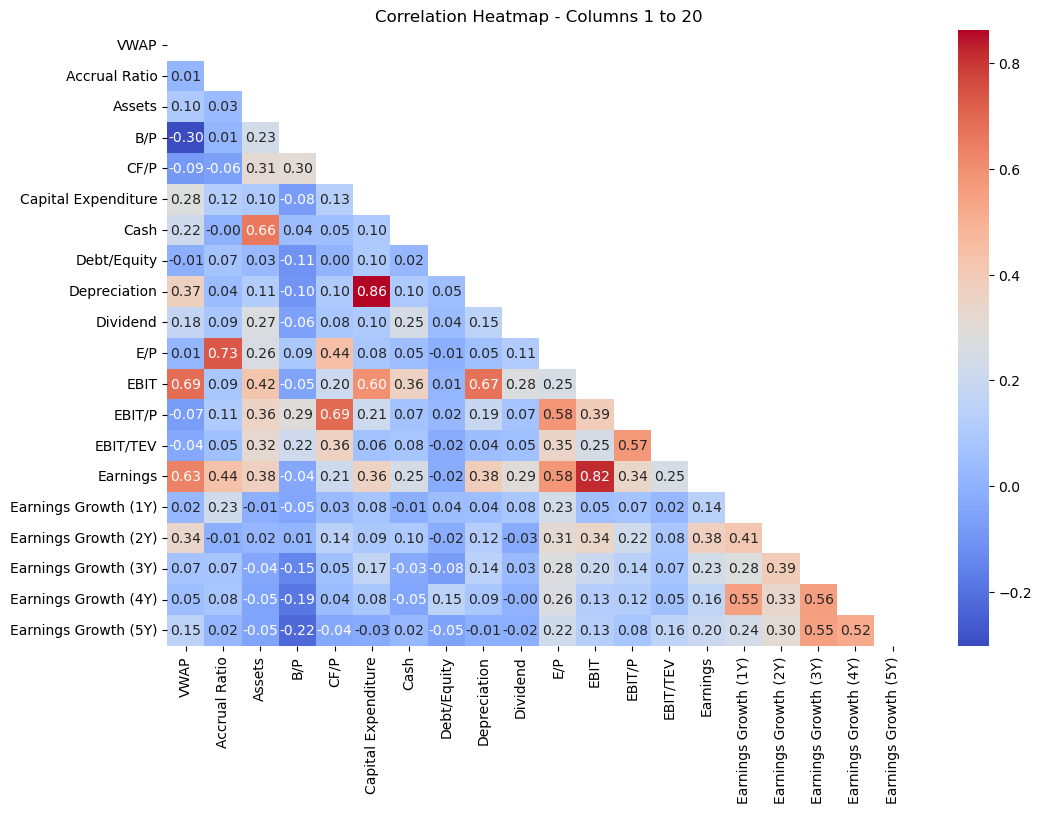

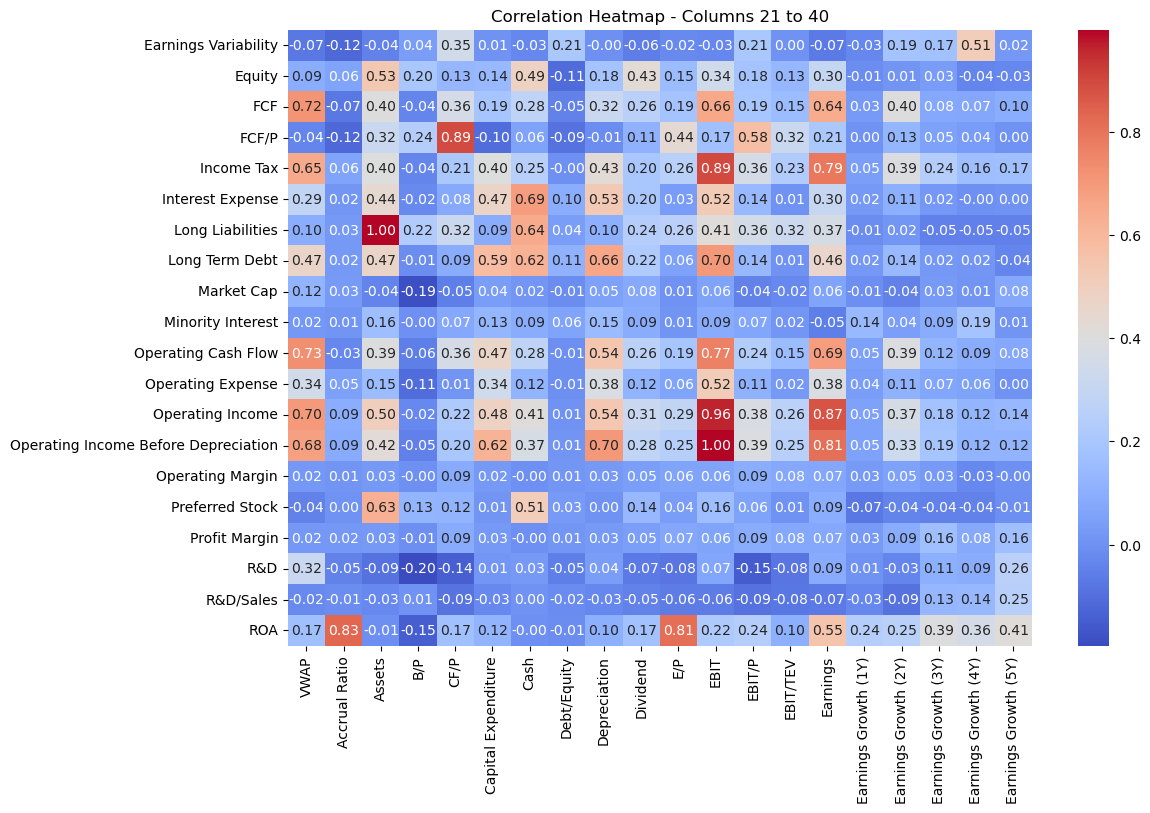

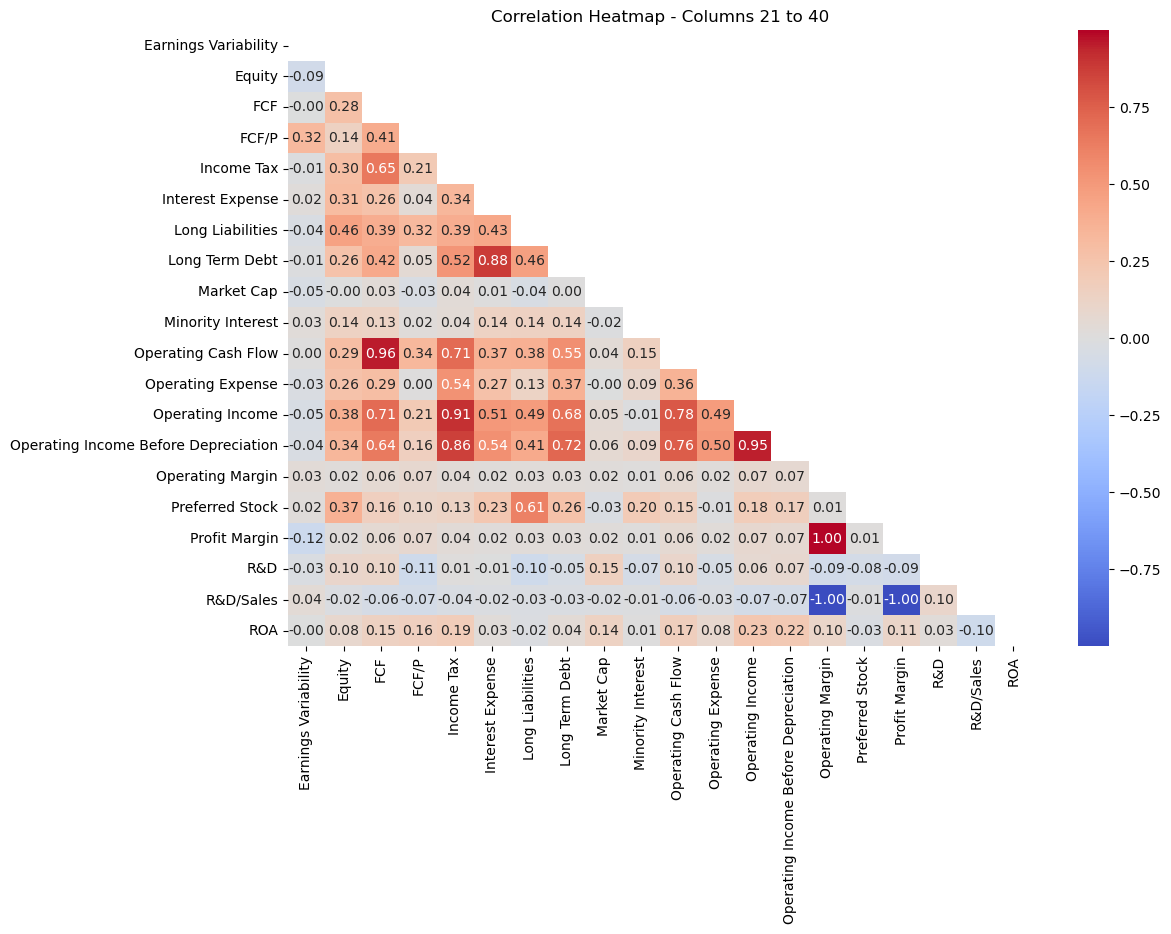

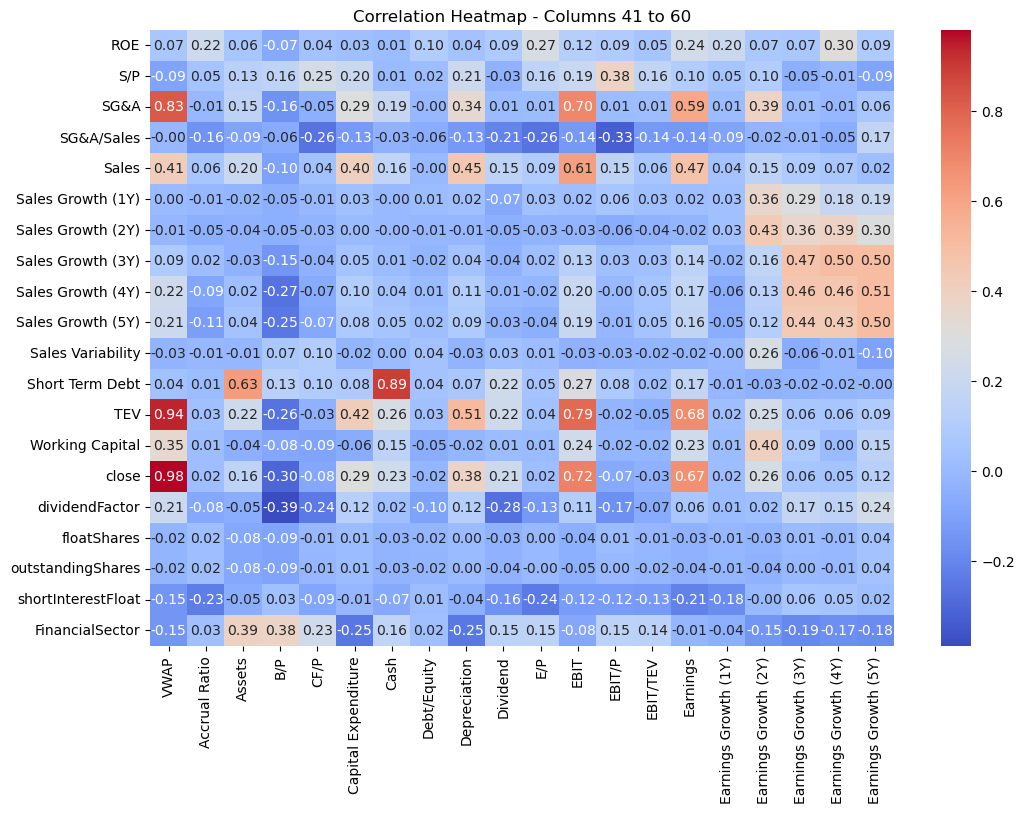

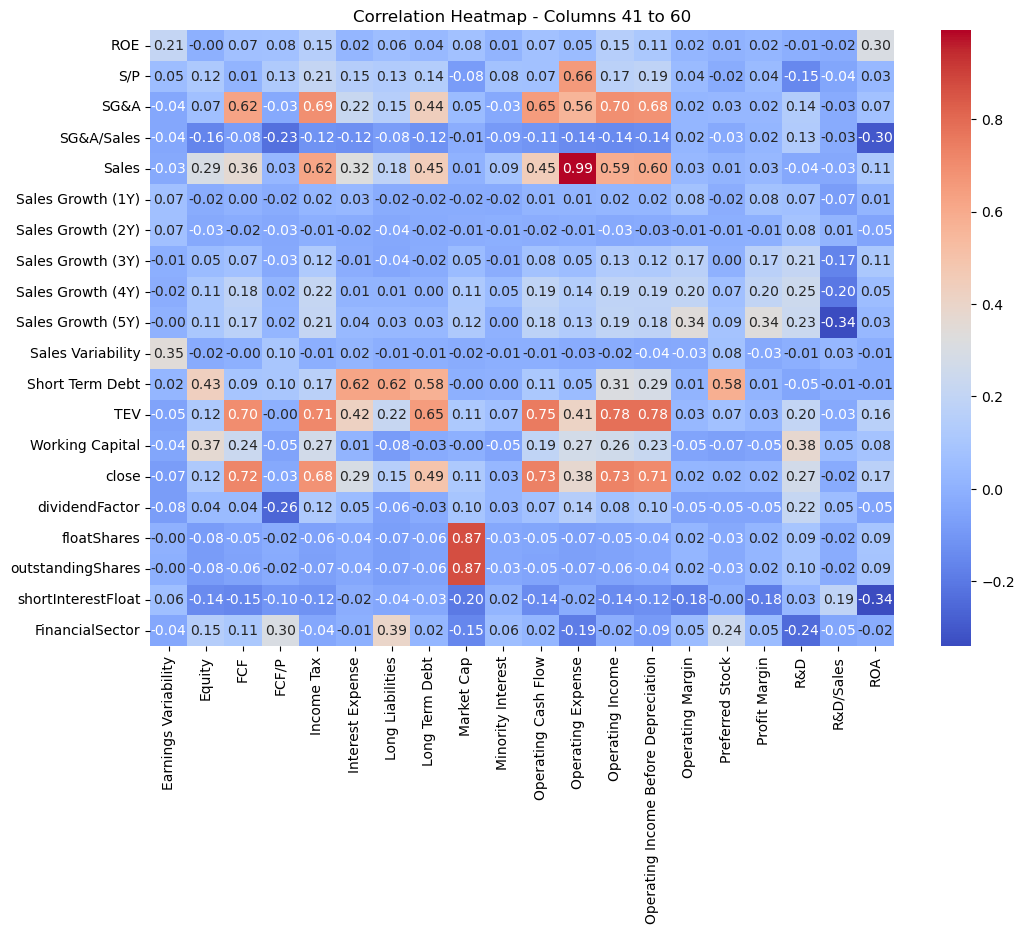

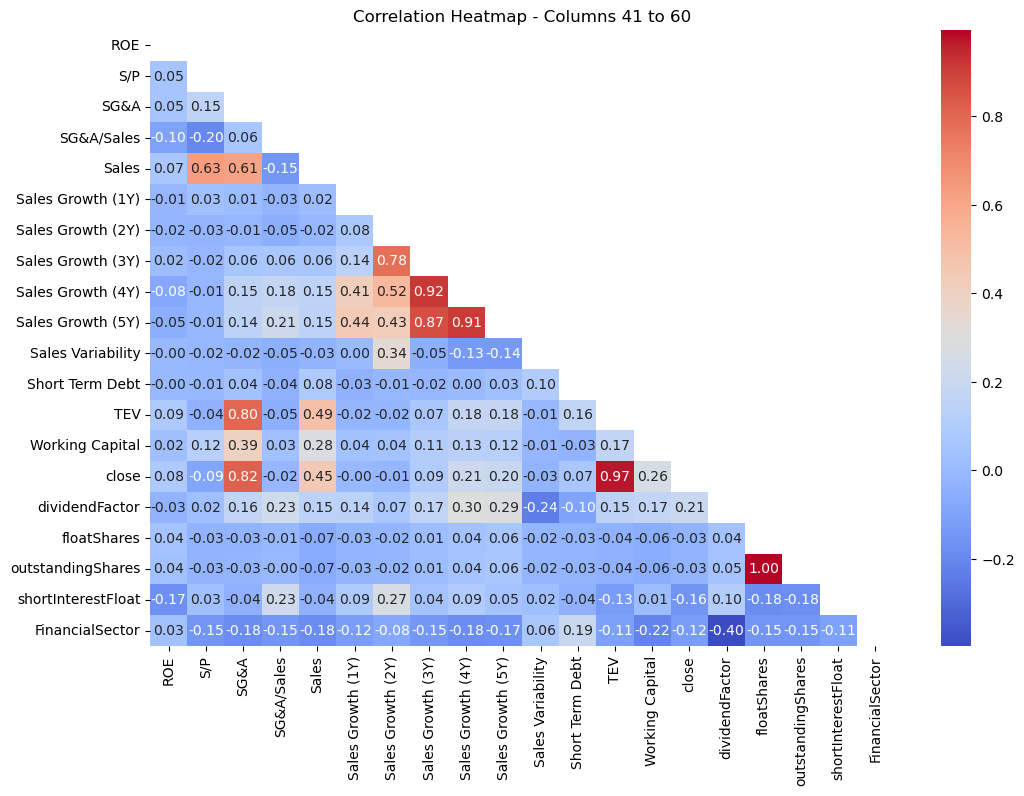

In [25]:
heatmap_segment_size = 20
num_columns = len(corr.columns)

for i in range(0, num_columns, heatmap_segment_size):
    for j in range(0, num_columns, heatmap_segment_size):
        subset_corr = corr.iloc[i:i+heatmap_segment_size, j:j+heatmap_segment_size]
        
        # skip subset with only nan values
        if all(subset_corr.isna().all()): continue
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(subset_corr, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title("Correlation Heatmap - Columns {} to {}".format(i+1, i+heatmap_segment_size))
        plt.show()

Obviously, there are many high correlations among the numerical variables. Therefore, it is necessary to drop some redundant variables considering multicollinearity when using regression-based models. Now let us explore the highest correlation variables.

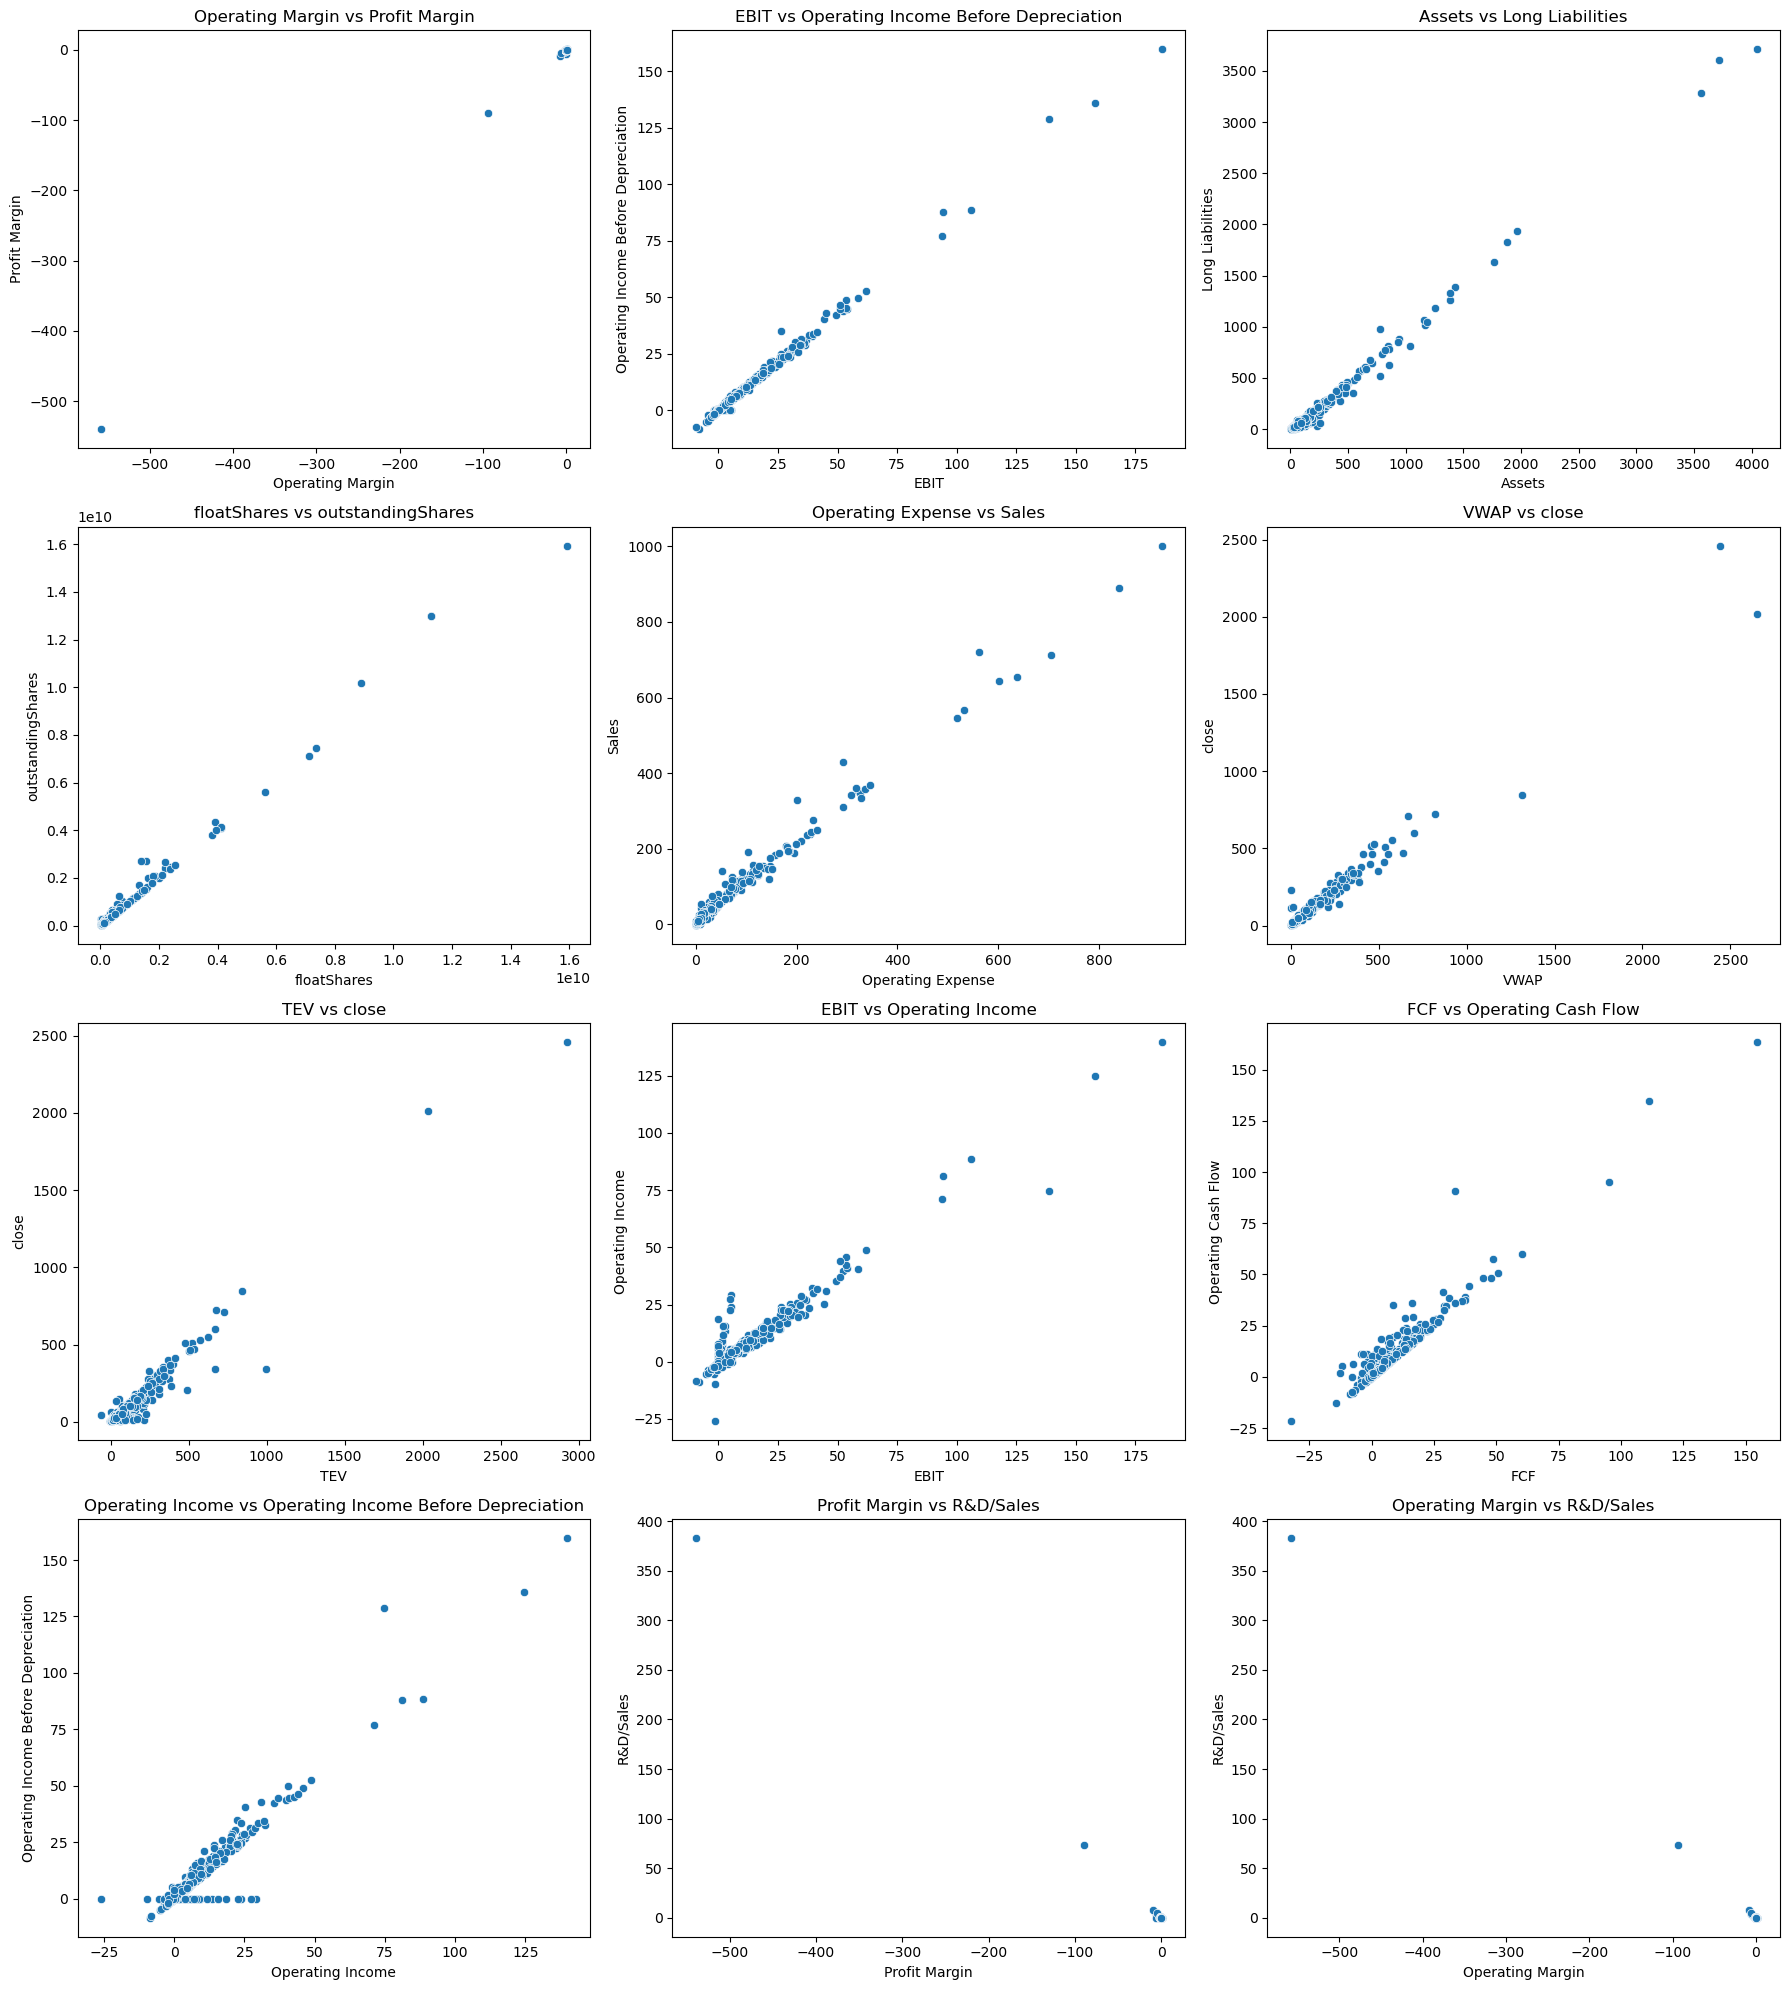

In [26]:
highest_corr = high_corr.index.tolist()

# Create a figure with subplots for each high correlation pair
num_plots = len(highest_corr)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 6, num_rows * 5))

for i, pair in enumerate(highest_corr, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(x=pair[0], y=pair[1], data=df_train)
    plt.title(f"{pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

From the graphs, all of these variable pairs show strong linear relationship, which makes sense in reality. We will drop one of the variables from each pairs later, according to their feature importance. 

Then, we will check those variable pairs with relatively high correlation (+-0.75-0.95).

In [27]:
# Identify moderate correlations (+-0.75 - 0.95)
moderate_corr = corr.unstack()
moderate_corr = moderate_corr[((moderate_corr >= 0.75) & (moderate_corr < 0.95)) | ((moderate_corr > -0.95) & (moderate_corr <= -0.75))]
moderate_corr = moderate_corr[moderate_corr != 1.0]  # Remove self-correlations

print(moderate_corr)

VWAP                                  SG&A                                    0.825839
                                      TEV                                     0.940631
Accrual Ratio                         ROA                                     0.832590
CF/P                                  FCF/P                                   0.890169
Capital Expenditure                   Depreciation                            0.863305
Cash                                  Short Term Debt                         0.891432
E/P                                   ROA                                     0.812939
EBIT                                  Earnings                                0.818374
                                      Income Tax                              0.894933
                                      Operating Cash Flow                     0.768768
                                      TEV                                     0.786009
Earnings                              Incom

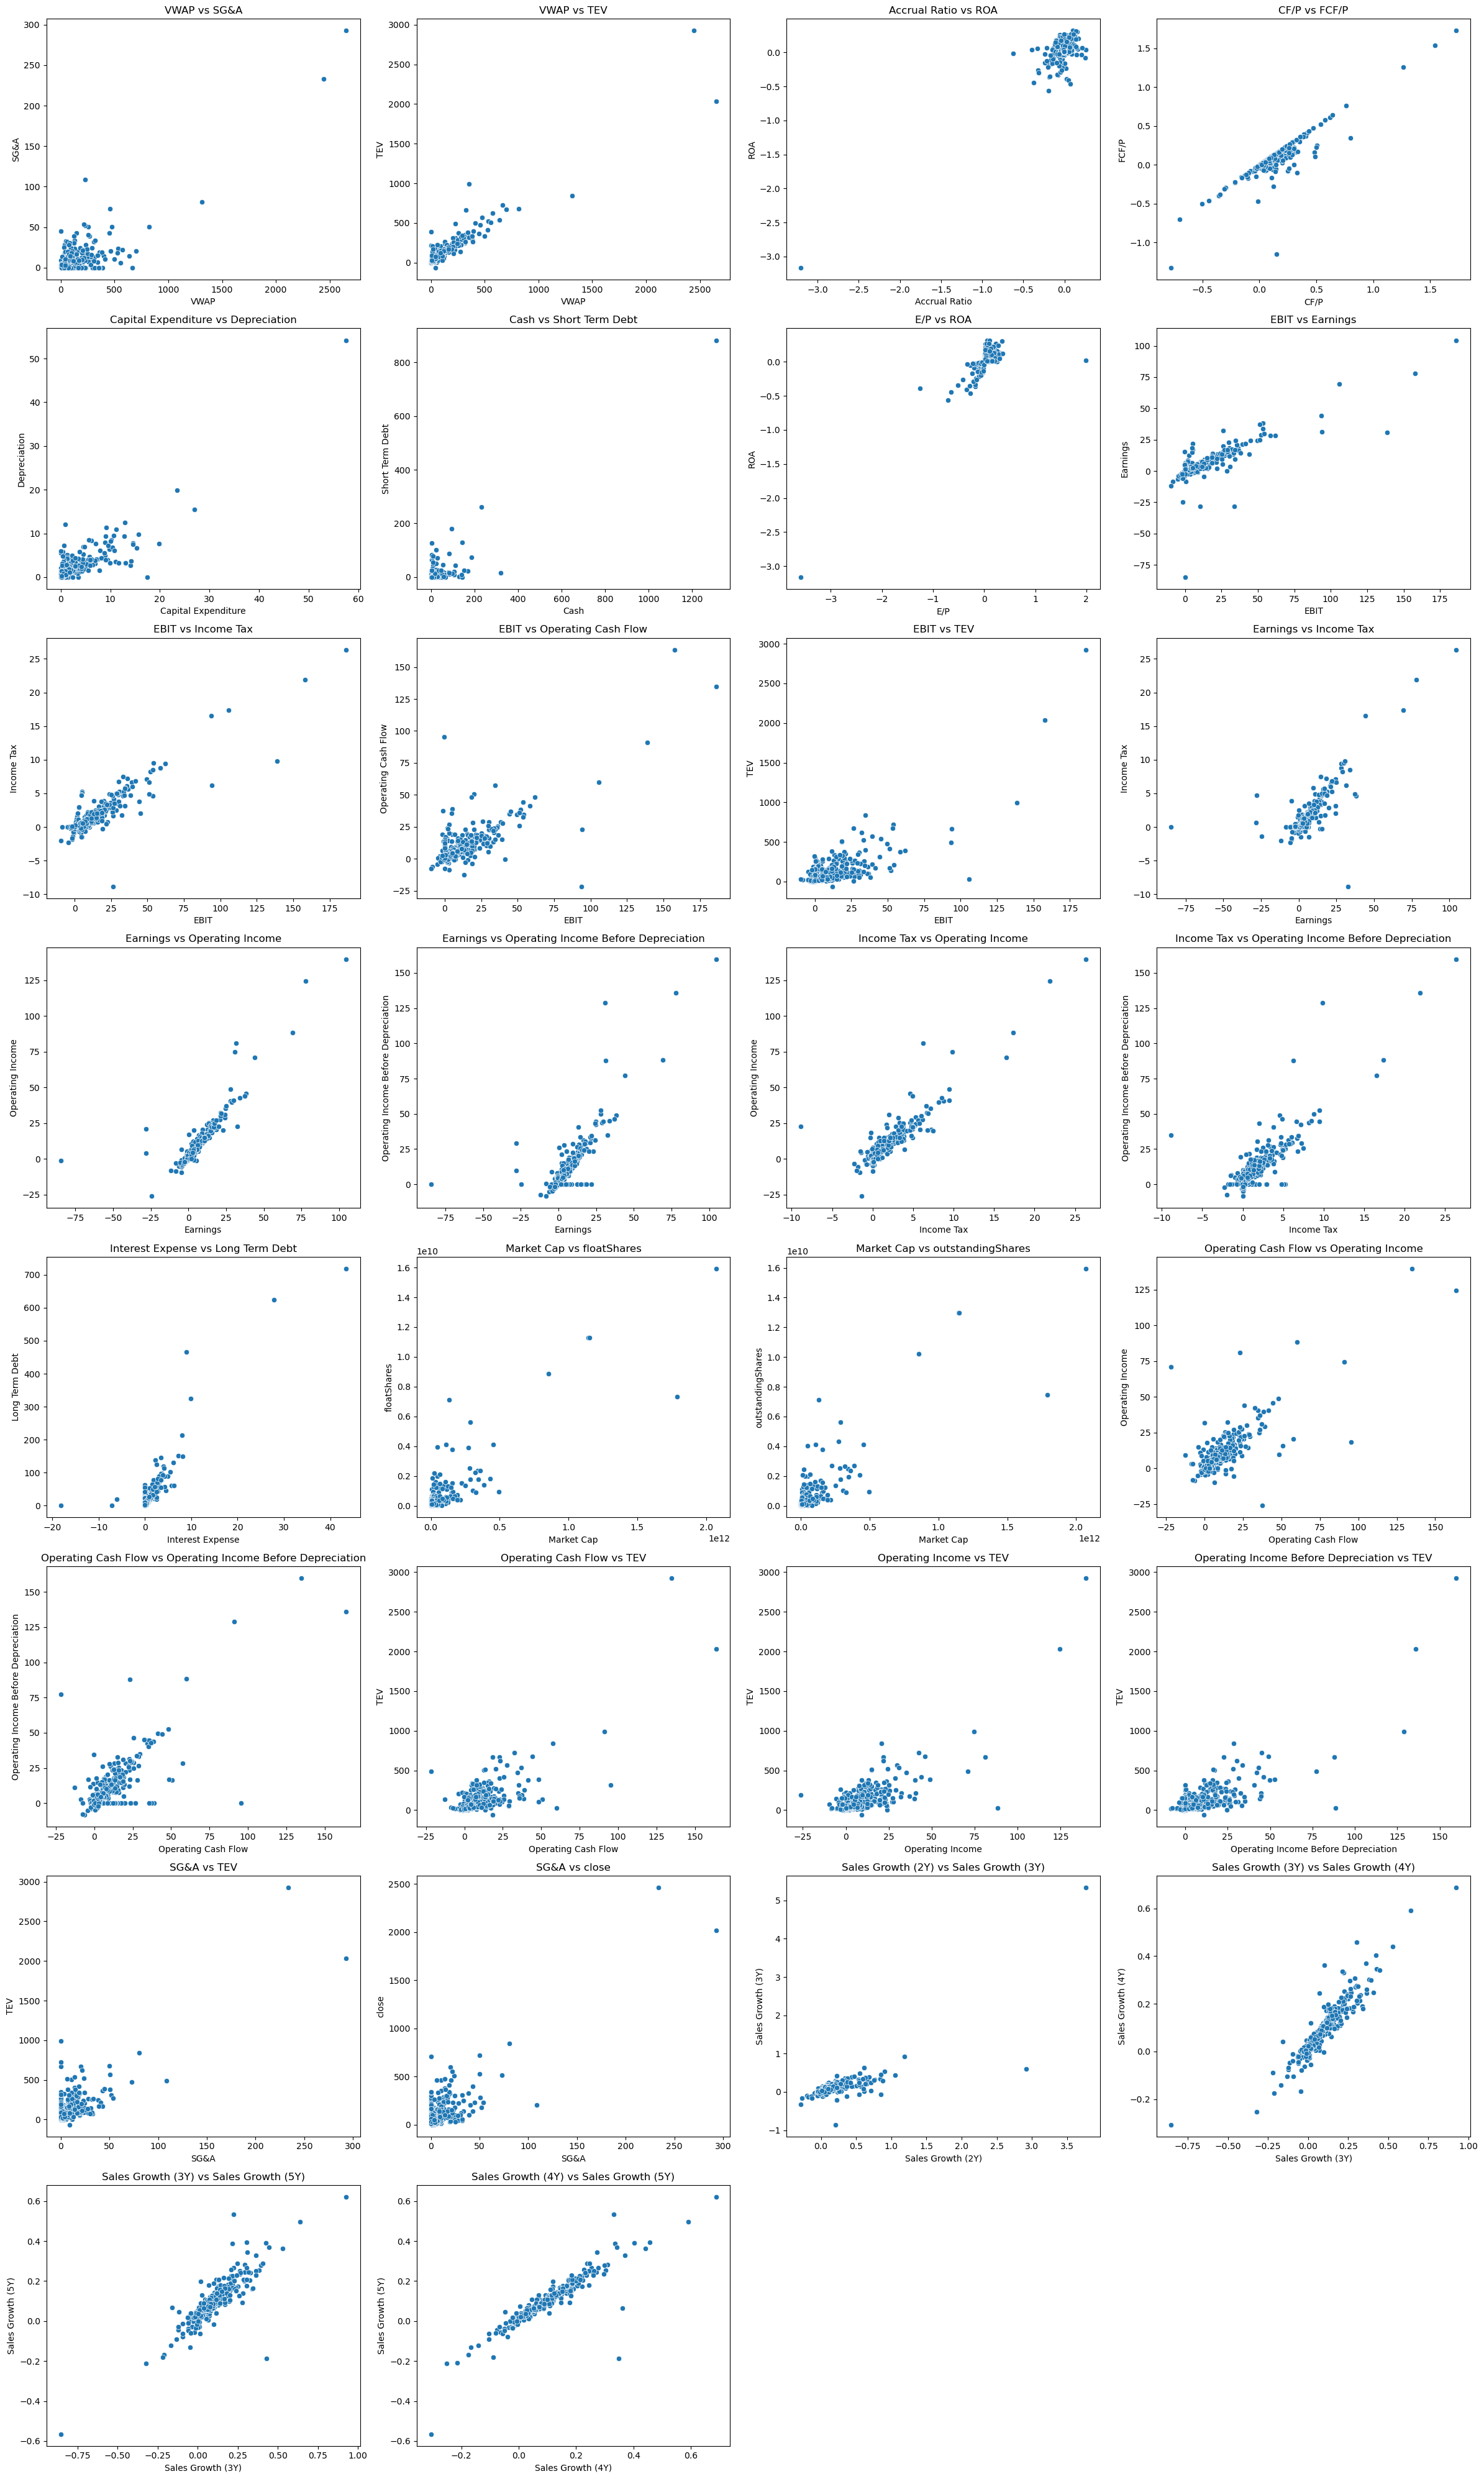

In [28]:
moderate_corr_pairs = moderate_corr.index.tolist()

# Create a figure with subplots for each high correlation pair
num_plots = len(moderate_corr_pairs)
num_cols = 4
num_rows = (num_plots + num_cols - 1) // num_cols

plt.figure(figsize=(num_cols * 6, num_rows * 5))

for i, pair in enumerate(moderate_corr_pairs, start=1):
    plt.subplot(num_rows, num_cols, i)
    sns.scatterplot(x=pair[0], y=pair[1], data=df_train)
    plt.title(f"{pair[0]} vs {pair[1]}")

plt.tight_layout()
plt.show()

For sales growth, it is obvious that there are linear relationships between 2Y - 3Y, 3Y - 4Y, 3Y - 5Y and 4Y - 5Y, which does make sense in reality. If the company does well over a five year period, it probaly does well in the first 3 or 4 years. Therefore, for regression model, we will keep 1Y, 2Y and 5Y as they are less correlated and still provide the time frame information.

For other linear correlated variable pairs, such as CF/P - FCF/P, Income Tax - Operation Income and Earnings - Operating Income, we need to drop one of them.

## Data Preprocessing

### Fill Missing Values

In [29]:
# Show missing values
df_train.isna().sum()

VWAP                                      0
incorporationCountry                      0
exchangeID                                3
Accrual Ratio                             0
Assets                                    0
B/P                                       0
CF/P                                      0
Capital Expenditure                       0
Cash                                      0
Debt/Equity                              18
Depreciation                              0
Dividend                                  0
E/P                                       0
EBIT                                      0
EBIT/P                                    0
EBIT/TEV                                 22
Earnings                                  0
Earnings Growth (1Y)                     64
Earnings Growth (2Y)                    138
Earnings Growth (3Y)                    111
Earnings Growth (4Y)                    108
Earnings Growth (5Y)                    121
Earnings Variability            

To fill missing values, we need to make sure:
1. the data is normally distributed, since some data is skewed.
2. the data is scaled, since there are outliers.

In [30]:
# Only take numerical features
def nan_impute_with_normalization(df_numerical_only, initial_strategy = 'median', imputation_order = 'roman'):

    pipe = make_pipeline(PowerTransformer(), 
                         IterativeImputer(initial_strategy = initial_strategy, # since too many outliers, mean will distort the parameter estimates
                                          imputation_order = imputation_order, # consideration for longitudinal variable
                                          skip_complete = True,
                                          verbose = 0),
                         Normalizer()).set_output(transform = 'pandas')

    return pipe.fit_transform(df_numerical_only)

df_pro = nan_impute_with_normalization(df_train[facts + ratios])

c:\Users\58447\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


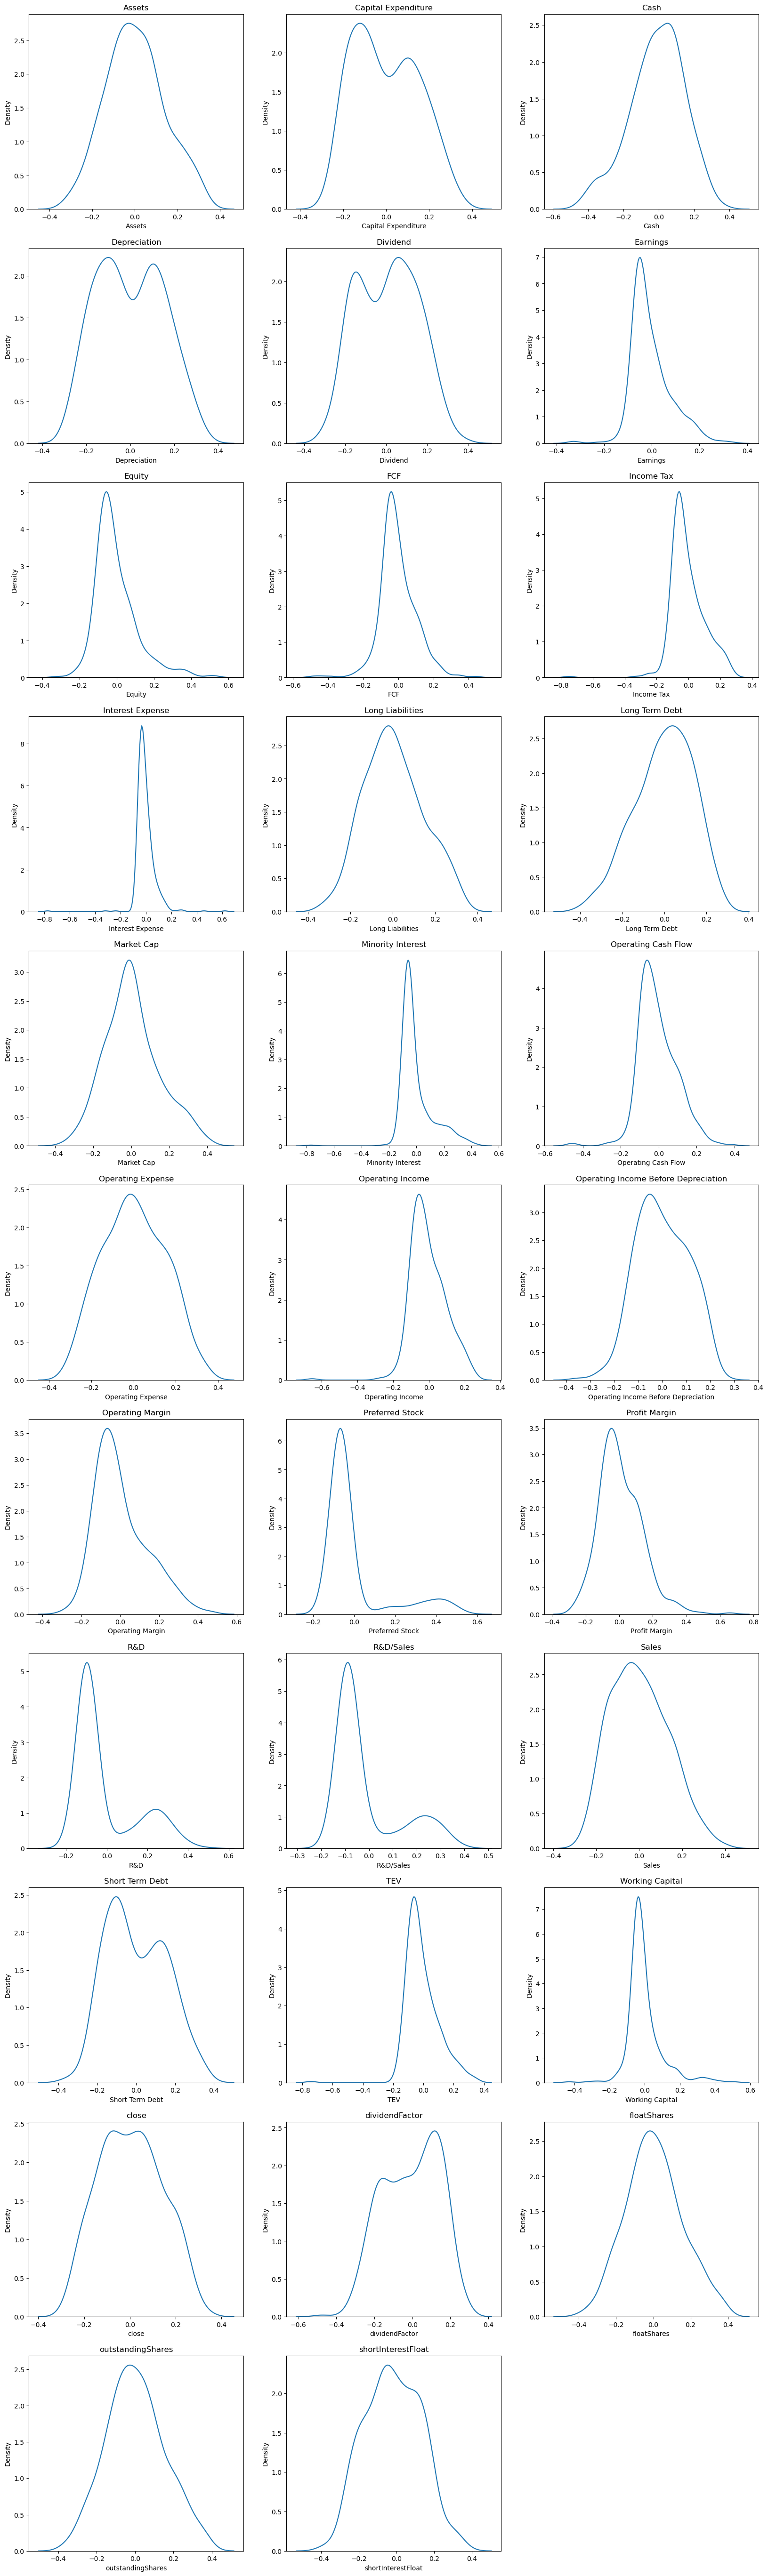

In [31]:
# Check distribution
f = plt.figure(figsize = [20, 70])
for i in range(len(facts)):
    f.add_subplot(11, 3, i+1)
    sns.kdeplot(x = facts[i], data = df_pro).set_title(facts[i])
plt.show()

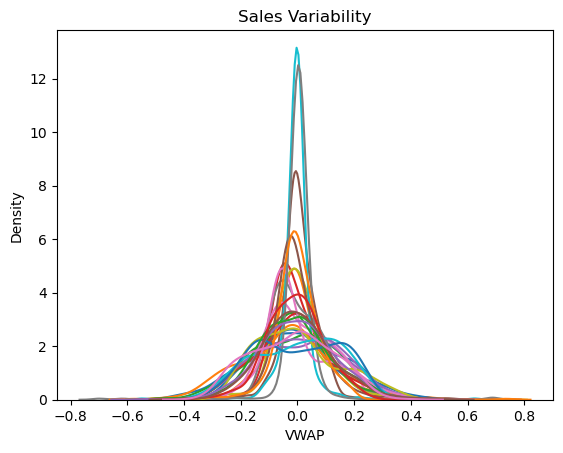

In [32]:
for i in range(len(ratios)):
    f.add_subplot(9, 3, i+1)
    sns.kdeplot(x = ratios[i], data = df_pro).set_title(ratios[i])
plt.show()

In [33]:
df_pro.isna().sum()

Assets                                  0
Capital Expenditure                     0
Cash                                    0
Depreciation                            0
Dividend                                0
Earnings                                0
Equity                                  0
FCF                                     0
Income Tax                              0
Interest Expense                        0
Long Liabilities                        0
Long Term Debt                          0
Market Cap                              0
Minority Interest                       0
Operating Cash Flow                     0
Operating Expense                       0
Operating Income                        0
Operating Income Before Depreciation    0
Operating Margin                        0
Preferred Stock                         0
Profit Margin                           0
R&D                                     0
R&D/Sales                               0
Sales                             

Now most of variables are transformed to near-normal distribution and the missing values are imputed by 'roman' imputation order. Meanwhile, all numericla data has been feature scaled.

### Encoding Categorical Variables

In [34]:
# Define y
y_train = pd.concat([df_train.iloc[:, -1]], axis=1)

In [35]:
# Categorical variable encoding
cat = df_train['incorporationCountry']
cat.replace(['USA', 'otherCountries'], [True, False], inplace = True)

# Combine the previous imputed and scaled dataframe with encoded variable 'incorporationCountry'. 
# exchangeID is not included according to previous analysis in EDA section
X_train = pd.concat([cat, df_pro], axis = 1)

### Feature Selection

Now we apply L1 regularization(Lasso regression) to do feature selection since some features are highly correlated.

In [36]:
def L1_regularization(X_train, y_train, alpha = 0.001, max_iter = 1000, tol = 1e-4):
    regularizer = Lasso(alpha = alpha, max_iter = max_iter, tol = tol)
    regularizer.fit(X_train, y_train)
    feature_importance = pd.DataFrame()
    feature_importance['feature'] = X_train.columns.tolist()
    feature_importance['importance'] = np.abs(regularizer.coef_)
    return feature_importance[feature_importance['importance'] != 0].sort_values('importance', ascending = False).reset_index().drop(['index'], axis = 1)

feature_importance = L1_regularization(X_train, y_train, alpha = 0.001)
feature_importance

feature  importance
0       Long Liabilities    1.353954
1       Operating Margin    0.824493
2                   SG&A    0.738638
3      Sales Growth (1Y)    0.631450
4                   Cash    0.590668
5            floatShares    0.435382
6    Capital Expenditure    0.416976
7        Working Capital    0.338396
8         Long Term Debt    0.308517
9          Profit Margin    0.271178
10                 FCF/P    0.255024
11   Operating Cash Flow    0.191992
12                   R&D    0.147591
13       Preferred Stock    0.142378
14      Operating Income    0.123355
15  Earnings Growth (2Y)    0.113725
16              Dividend    0.107785
17          Depreciation    0.105800
18     Minority Interest    0.100150
19              EBIT/TEV    0.097162
20     Sales Growth (2Y)    0.095997
21  incorporationCountry    0.093118
22    shortInterestFloat    0.092175
23             R&D/Sales    0.071243
24  Earnings Growth (3Y)    0.053880
25         Accrual Ratio    0.046467
26      Interest Expense    0.041889
27                   B/P    0.036837
28                   E/P    0.030992
29            SG&A/Sales    0.020080
30  Earnings Variability    0.011613
31       Short Term Debt    0.006664
32                 Sales    0.006477

In [37]:
# We will select all the variables from future selection and from those,
# we will drop one from each pairs of the high-correclated variables based on the previous correlation analysis,
# which are 'Profit Margin','R&D/Sales',

X_train_selected = X_train[['Long Liabilities', 'Operating Margin', 'SG&A', 'Sales Growth (1Y)', 'Cash', 'floatShares', 'Capital Expenditure', 'Working Capital', 'Long Term Debt', 'FCF/P', 'Operating Income','Operating Cash Flow', 'R&D', 'Preferred Stock',  'Earnings Growth (2Y)', 'Dividend', 'Depreciation', 'Minority Interest', 'EBIT/TEV', 'Sales Growth (2Y)', 'incorporationCountry', 'shortInterestFloat',  'Earnings Growth (3Y)', 'Accrual Ratio', 'Interest Expense', 'B/P', 'E/P', 'SG&A/Sales', 'Earnings Variability', 'Short Term Debt', 'Sales']]
X_train_selected.head()

Long Liabilities  Operating Margin      SG&A  Sales Growth (1Y)  \
ticker                                                                    
FICO            0.042814          0.070167  0.152451           0.008898   
RXRX           -0.184998         -0.259800 -0.042637          -0.008952   
BLDR           -0.022237         -0.036716  0.167738           0.076407   
JKHY           -0.169779         -0.018976  0.068905          -0.029869   
OC              0.029284         -0.049406  0.140853           0.039062   

            Cash  floatShares  Capital Expenditure  Working Capital  \
ticker                                                                
FICO   -0.003213    -0.221909            -0.091727         0.004161   
RXRX   -0.043592    -0.021001            -0.069181        -0.010030   
BLDR   -0.188755    -0.006860             0.091428         0.046484   
JKHY   -0.366145    -0.146925            -0.102316        -0.047216   
OC      0.103773    -0.083045             0.237441         0.112795   

        Long Term Debt     FCF/P  Operating Income  Operating Cash Flow  \
ticker                                                                    
FICO          0.168537 -0.023370          0.120864             0.093359   
RXRX         -0.161732 -0.067163         -0.080186            -0.069585   
BLDR          0.054467  0.141556          0.132512             0.125411   
JKHY         -0.165009 -0.035251         -0.011981            -0.006038   
OC            0.139676  0.079866          0.143574             0.142640   

             R&D  Preferred Stock  Earnings Growth (2Y)  Dividend  \
ticker                                                              
FICO    0.224349        -0.051489              0.018354 -0.149666   
RXRX    0.117235        -0.037166             -0.272320 -0.108034   
BLDR   -0.072592        -0.052225              0.230840 -0.151805   
JKHY    0.360867        -0.091466             -0.061241  0.143631   
OC      0.275280        -0.080178              0.297435  0.069382   

        Depreciation  Minority Interest  EBIT/TEV  Sales Growth (2Y)  \
ticker                                                                 
FICO       -0.015589          -0.049719 -0.032920          -0.024668   
RXRX       -0.097513          -0.035889 -0.236519          -0.010793   
BLDR        0.123615          -0.050430  0.156096           0.128733   
JKHY        0.180819          -0.088322 -0.035026          -0.053037   
OC          0.262166           0.062603  0.156561           0.096627   

        incorporationCountry  shortInterestFloat  Earnings Growth (3Y)  \
ticker                                                                   
FICO                    True            0.022781              0.075088   
RXRX                    True            0.166771             -0.287876   
BLDR                    True            0.060083              0.278475   
JKHY                    True            0.008128             -0.008930   
OC                      True            0.076685              0.223467   

        Accrual Ratio  Interest Expense       B/P       E/P  SG&A/Sales  \
ticker                                                                    
FICO        -0.078377          0.096343 -0.203432 -0.013890    0.108353   
RXRX        -0.155492         -0.026154 -0.024635 -0.087891    0.202005   
BLDR        -0.075640          0.013161  0.022533  0.125707    0.009171   
JKHY        -0.109938         -0.056287 -0.212425 -0.022189    0.024355   
OC          -0.013580          0.024752  0.055470  0.089968   -0.082392   

        Earnings Variability  Short Term Debt     Sales  
ticker                                                   
FICO               -0.096559         0.093148  0.061703  
RXRX                0.102626        -0.104342 -0.169536  
BLDR                0.032885        -0.050685  0.147841  
JKHY               -0.285515        -0.220960  0.007456  
OC                  0.256930        -0.059997  0.180676

Then, we will check multicollinearity with VIF for regularized features

In [38]:
alpha = 0.001

 # drop incorporationCountry since VIF cannot process bool
X_LR = X_train_selected.drop(['incorporationCountry'], axis = 1)

# calculate VIF
def VIF(X):
    vif_df = pd.DataFrame() 
    vif_df["feature"] = X.columns 

    # calculating VIF for each feature 
    vif_df["VIF"] = [variance_inflation_factor(X.values, i) 
                              for i in range(len(X.columns))] 
    return vif_df
VIF(X_LR)

feature        VIF
0       Long Liabilities   5.089982
1       Operating Margin   3.015323
2                   SG&A  10.642223
3      Sales Growth (1Y)   1.994013
4                   Cash   2.394979
5            floatShares   1.613082
6    Capital Expenditure   4.328693
7        Working Capital   1.614221
8         Long Term Debt   3.490988
9                  FCF/P   2.897933
10      Operating Income   3.241906
11   Operating Cash Flow   3.146198
12                   R&D   1.991152
13       Preferred Stock   1.482065
14  Earnings Growth (2Y)   3.104341
15              Dividend   1.820823
16          Depreciation   3.783506
17     Minority Interest   1.340188
18              EBIT/TEV   2.913626
19     Sales Growth (2Y)   2.638585
20    shortInterestFloat   1.683616
21  Earnings Growth (3Y)   3.106996
22         Accrual Ratio   2.191807
23      Interest Expense   1.871007
24                   B/P   2.001330
25                   E/P   3.346255
26            SG&A/Sales   9.868555
27  Earnings Variability   1.927373
28       Short Term Debt   1.940748
29                 Sales  11.522985

In [39]:
# We will drop 'SG&A', 'Sales' since their VIF values are high

X_LR = X_LR.drop(['SG&A', 'Sales'], axis = 1)

Finally, we check multicollinearity with correlation

<Axes: >

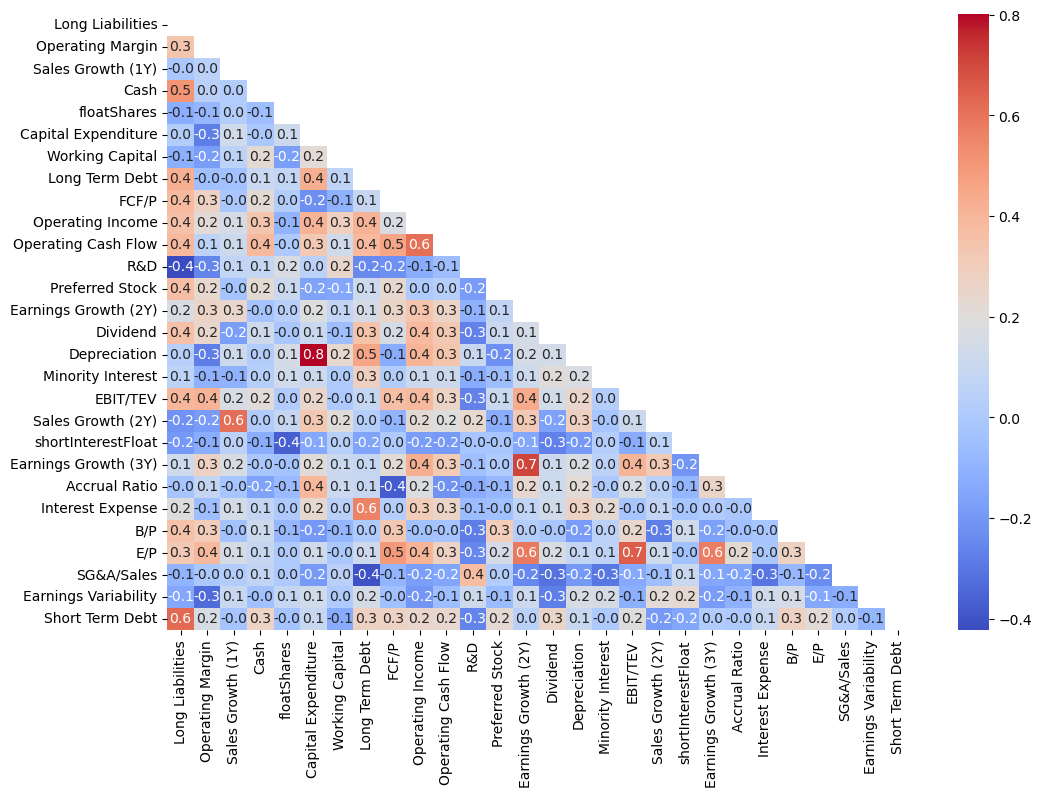

In [40]:
corr_LR = X_LR.corr().where(np.tril(np.ones_like(X_LR.corr(), dtype = bool), k = -1))
plt.figure(figsize=(12, 8))
sns.heatmap(corr_LR, annot=True, cmap='coolwarm', fmt=".1f")

In [41]:
# drop less important features with corr >= 0.6
X_train_final = X_LR.drop(['Depreciation', 'Earnings Growth (3Y)', 'E/P','Operating Income', 'Sales Growth (2Y)', 'Interest Expense','Short Term Debt'], axis = 1)

We now have a well-prepared dataset with featured variables. Let us move to the next step.  

## Models Building

### Base Classifier

In [42]:
# train base classifier model
dummy_cf = DummyClassifier()
dummy_cf.fit(X_train_final, y_train)
y_train_pred1 = dummy_cf.predict(X_train_final)
accuracy_score(y_train_pred1, y_train)

0.6457831325301204

The accuracy score of this model is low, and we will not adopt it.

### Logistic Regression

In [43]:
LR = LogisticRegression()

scoring = ['accuracy','precision','recall', 'roc_auc']

# Apply cross validation to aviod overfitting 
cv_LR = cross_validate(
    LR,
    X_train_final,
    y_train,
    scoring=scoring,
    cv=5
)

cv_LR_accuracy = cv_LR['test_accuracy'].mean()
cv_LR_precision = cv_LR['test_precision'].mean()
cv_LR_recall = cv_LR['test_recall'].mean()
cv_LR_auc = cv_LR['test_roc_auc'].mean()

print('LR accuracy:', '{:,}'.format(cv_LR_accuracy))
print('LR precision:', '{:,}'.format(cv_LR_precision))
print('LR recall:', '{:,}'.format(cv_LR_recall))
print('LR auc:', '{:,}'.format(cv_LR_auc))

LR accuracy: 0.9277108433734942
LR precision: 0.9400846560846562
LR recall: 0.8514942528735633
LR auc: 0.9805113376225932


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

This model is quite acceptable since the accuracy score, precision score, recall_score and auc is relatively high.

### Random Forest

In [44]:
RF = RandomForestClassifier()

scoring = ['accuracy','precision','recall', 'roc_auc']

# Apply cross validation to aviod overfitting 
cv_RF = cross_validate(RF,
                       X_train_final,
                       y_train,
                      scoring = scoring)

cv_RF_accuracy = cv_RF['test_accuracy'].mean()
cv_RF_precision = cv_RF['test_precision'].mean()
cv_RF_recall = cv_RF['test_recall'].mean()
cv_RF_auc = cv_RF['test_roc_auc'].mean()

print('RF accuracy:', '{:,}'.format(cv_RF_accuracy))
print('RF precision:', '{:,}'.format(cv_RF_precision))
print('RF recall:', '{:,}'.format(cv_RF_recall))
print('RF auc:', '{:,}'.format(cv_RF_auc))

c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

RF accuracy: 0.9421686746987952
RF precision: 0.9555555555555555
RF recall: 0.8781609195402298
RF auc: 0.9828701896431239


Every score of this model is almost 100% and from the confusion matrix, it predicts every case correctly. However, this may cause overfitting problem.

### Naive Bayes

In [45]:
NB = GaussianNB()

scoring = ['accuracy','precision','recall', 'roc_auc']

# Apply cross validation to aviod overfitting 
cv_NB = cross_validate(NB,
                       X_train_final,
                       y_train,
                      scoring = scoring)

cv_NB_accuracy = cv_NB['test_accuracy'].mean()
cv_NB_precision = cv_NB['test_precision'].mean()
cv_NB_recall = cv_NB['test_recall'].mean()
cv_NB_auc = cv_NB['test_roc_auc'].mean()

print('NB accuracy:', '{:,}'.format(cv_NB_accuracy))
print('NB precision:', '{:,}'.format(cv_NB_precision))
print('NB recall:', '{:,}'.format(cv_NB_recall))
print('NB auc:', '{:,}'.format(cv_NB_auc))

NB accuracy: 0.9132530120481928
NB precision: 0.8660768398268399
NB recall: 0.8986206896551725
NB auc: 0.9580211571363165


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,

### XGBoost

In [46]:
XGB = XGBClassifier()

scoring = ['accuracy','precision','recall', 'roc_auc']

cv_XGB = cross_validate(XGB,
                       X_train_final,
                       y_train,
                      scoring = scoring)

cv_XGB_accuracy = cv_XGB['test_accuracy'].mean()
cv_XGB_precision = cv_XGB['test_precision'].mean()
cv_XGB_recall = cv_XGB['test_recall'].mean()
cv_XGB_auc = cv_XGB['test_roc_auc'].mean()

print('XGB accuracy:', '{:,}'.format(cv_XGB_accuracy))
print('XGB precision:', '{:,}'.format(cv_XGB_precision))
print('XGB recall:', '{:,}'.format(cv_XGB_recall))
print('XGB auc:', '{:,}'.format(cv_XGB_auc))

XGB accuracy: 0.946987951807229
XGB precision: 0.9639029374201786
XGB recall: 0.8850574712643677
XGB auc: 0.9817402828983832


## Hyperparameter Tuning

### Define parameter for each model

In [47]:
# naive bayes does not contain hyperparameters, we do not consider naive bayes here.
param_lr = {'solver': ['liblinear', 'saga'],
            'tol': [1e-2, 1e-4],
            'C': [1, 3, 5, 10, 50, 100, 1000]}
param_rf = {'criterion': ['entropy'], 
            'n_estimators': [10, 20, 30, 50, 100], 
            'max_depth': [None, 10, 20, 30, 50], 
            'min_samples_split': [2, 5, 10]}
param_xgb = {'learning_rate': [0.1, 0.01, 0.001], 
             'max_depth': [3, 5, 7, 20], 
             'n_estimators': [10, 20, 50, 100, 200]}

### Grid Search

In [48]:
# Hyperparameter tuning of logistic regression model
grid_search1 = GridSearchCV(estimator=LR,
                            param_grid= param_lr,
                            scoring = 'accuracy',
                            cv = 10,
                            n_jobs = -1)

grid_search1.fit(X_train_final, y_train)

best_accuracy1 = grid_search1.best_score_
best_parameters1 = grid_search1.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy1*100))
print("Best Parameters:", best_parameters1)

Best Accuracy: 94.19%
Best Parameters: {'C': 5, 'solver': 'saga', 'tol': 0.0001}


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The best parameters for logistic regression model of this problem is C = 5, solver = 'saga', tol = 0.0001 with an 94.19% accuracy.

In [49]:
# Hyperparameter tuning of random forest model
grid_search2 = GridSearchCV(estimator=RF,
                            param_grid= param_rf,
                            scoring = 'accuracy',
                            cv = 10,
                            n_jobs = -1)

grid_search2.fit(X_train_final, y_train)

best_accuracy2 = grid_search2.best_score_
best_parameters2 = grid_search2.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy2*100))
print("Best Parameters:", best_parameters2)

Best Accuracy: 94.93%
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10, 'n_estimators': 20}


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


The best parameters for random forest model of this problem is criterion= 'entropy', max_depth = None, min_samples_split =  10, n_estimators = 50 with an 95.39% accuracy.

In [50]:
# Hyperparameter tuning of XGBoost model
grid_search3 = GridSearchCV(estimator=XGB,
                            param_grid= param_xgb,
                            scoring = 'accuracy',
                            cv = 10,
                            n_jobs = -1)

grid_search3.fit(X_train_final, y_train)

best_accuracy3 = grid_search3.best_score_
best_parameters3 = grid_search3.best_params_
print("Best Accuracy: {:.2f}%".format(best_accuracy3*100))
print("Best Parameters:", best_parameters3)

Best Accuracy: 95.17%
Best Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}


The best parameters for XGBoost model of this problem is learning_rate =  0.1, max_depth =  3, n_estimators = 100 with an 95.17% accuracy.

Comparing the 5 models mentioned before, we finally select random forest model since after hyperparameter tuning, random forest has the highest accuracy score.

In [51]:
classifier = RandomForestClassifier(criterion= 'entropy', max_depth = None, min_samples_split=10, n_estimators=50, random_state=42)

scoring = ['accuracy','precision','recall', 'roc_auc']

# Apply cross validation to aviod overfitting 
cv_RF = cross_validate(classifier,
                       X_train_final,
                       y_train,
                      scoring = scoring)

cv_RF_accuracy = cv_RF['test_accuracy'].mean()
cv_RF_precision = cv_RF['test_precision'].mean()
cv_RF_recall = cv_RF['test_recall'].mean()
cv_RF_auc = cv_RF['test_roc_auc'].mean()

print('RF accuracy:', '{:,}'.format(cv_RF_accuracy))
print('RF precision:', '{:,}'.format(cv_RF_precision))
print('RF recall:', '{:,}'.format(cv_RF_recall))
print('RF auc:', '{:,}'.format(cv_RF_auc))

c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for

RF accuracy: 0.9445783132530121
RF precision: 0.9771851851851853
RF recall: 0.8645977011494252
RF auc: 0.9848478276584979


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [52]:
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train_final, y_train, test_size= 0.2, random_state=42)

classifier.fit(X_train_train, y_train_train)

c:\Users\58447\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(criterion='entropy', min_samples_split=10,
                       n_estimators=50, random_state=42)

In [53]:
y_train_test_pred = classifier.predict(X_train_test)

print(confusion_matrix(y_train_test_pred, y_train_test))
print(classification_report(y_train_test_pred, y_train_test)) 
print('accuracy score:', accuracy_score(y_train_test_pred, y_train_test))  
print('auc:', roc_auc_score(y_train_test_pred, y_train_test))

[[54  1]
 [ 5 23]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        55
           1       0.96      0.82      0.88        28

    accuracy                           0.93        83
   macro avg       0.94      0.90      0.92        83
weighted avg       0.93      0.93      0.93        83

accuracy score: 0.927710843373494
auc: 0.9016233766233767


## Predict

Now we will read the test data

In [54]:
df_test = pd.read_parquet('F:/United States/University of Southern California/Semester 2/Data Mining/Final/navigating-financial-instability/20231124_Financial_Risk_Project_test_public (1).parquet')
df_test.head()

url  \
ticker                                                      
JAZZ    https://seekingalpha.com/article/4649579-jazz-...   
WAL     https://seekingalpha.com/article/4642312-weste...   
PGR     https://seekingalpha.com/article/4646049-progr...   
ARES    https://seekingalpha.com/article/4645462-ares-...   
CBSH    https://seekingalpha.com/article/4480797-comme...   

                                          call_transcript    VWAP  \
ticker                                                              
JAZZ    Jazz Pharmaceuticals PLC (JAZZ) Q3 2023 Earnin...  146.04   
WAL     Western Alliance Bancorporation (WAL) Q3 2023 ...   35.70   
PGR     Progressive Corporation (PGR) Q3 2023 Earnings...  143.19   
ARES    Ares Management Corporation (ARES) Q3 2023 Ear...   83.00   
CBSH    Commerce Bancshares, Inc. 2022 Q4 - Results - ...   58.44   

       exchangeCountry        securityType         CIK  \
ticker                                                   
JAZZ               USA  Common or ordinary  0001232524   
WAL                USA  Common or ordinary  0001212545   
PGR                USA  Common or ordinary  0000080661   
ARES               USA  Common or ordinary  0001176948   
CBSH               USA  Common or ordinary  0000022356   

                                   name  securityID incorporationCountry  \
ticker                                                                     
JAZZ           Jazz Pharmaceuticals plc  1772870101                  IRL   
WAL     Western Alliance Bancorporation  1639200101                  USA   
PGR              Progressive Corp (The)   133410101                  USA   
ARES               Ares Management Corp   204120101                  USA   
CBSH            Commerce Bancshares Inc    32380101                  USA   

                   exchangeName exchangeID  Accrual Ratio      Assets  \
ticker                                                                  
JAZZ        Nasdaq Stock Market          T      -0.135464  171.846333   
WAL     New York Stock Exchange          N      -0.015565  624.852399   
PGR     New York Stock Exchange          N      -0.077571  128.232795   
ARES    New York Stock Exchange          N       0.044935  115.908123   
CBSH        Nasdaq Stock Market          T      -0.000170  255.848678   

             B/P      CF/P  Capital Expenditure       Cash  Debt/Equity  \
ticker                                                                    
JAZZ    0.307191  0.126675             0.459623  13.980239     1.885266   
WAL     0.783885  0.350089             1.307663   9.621771     1.457617   
PGR     0.201706  0.089970             0.497450  15.215293     0.423814   
ARES    0.122235 -0.059914             0.201206   5.871717     8.396728   
CBSH    0.290692  0.065428             0.519484   7.152646     1.166855   

        Depreciation  Dividend       E/P       EBIT    EBIT/P  EBIT/TEV  \
ticker                                                                    
JAZZ        9.985168  0.000000 -0.022335  22.285491  0.139888  0.093797   
WAL         0.486394  1.543787  0.164842  19.698248  0.330729  0.163182   
PGR         0.573333  0.444249  0.009447   3.278489  0.025276  0.025933   
ARES        0.860399  0.000000  0.013247   5.188796  0.075815  0.034526   
CBSH        0.373147  1.015124  0.057158   7.877052  0.115720  0.093622   

        Earnings  Earnings Growth (1Y)  Earnings Growth (2Y)  \
ticker                                                         
JAZZ   -3.558125                   NaN                   NaN   
WAL     9.817977              0.128896              0.395197   
PGR     1.225357             -0.785315             -0.644697   
ARES    0.906632             -0.597082             -0.004828   
CBSH    3.890717             -0.061115              0.188244   

        Earnings Growth (3Y)  Earnings Growth (4Y)  Earnings Growth (5Y)  \
ticker                                                                     
JAZZ                     NaN         

In [55]:
# See whether there is nan value
df_test.info()
df_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, JAZZ to FIVE
Data columns (total 71 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   url                                   104 non-null    object 
 1   call_transcript                       104 non-null    object 
 2   VWAP                                  104 non-null    float64
 3   exchangeCountry                       104 non-null    object 
 4   securityType                          104 non-null    object 
 5   CIK                                   104 non-null    object 
 6   name                                  104 non-null    object 
 7   securityID                            104 non-null    int64  
 8   incorporationCountry                  104 non-null    object 
 9   exchangeName                          104 non-null    object 
 10  exchangeID                            104 non-null    object 
 11  Accrual Ratio       

url                                      0
call_transcript                          0
VWAP                                     0
exchangeCountry                          0
securityType                             0
CIK                                      0
name                                     0
securityID                               0
incorporationCountry                     0
exchangeName                             0
exchangeID                               0
Accrual Ratio                            0
Assets                                   0
B/P                                      0
CF/P                                     0
Capital Expenditure                      0
Cash                                     0
Debt/Equity                              1
Depreciation                             0
Dividend                                 0
E/P                                      0
EBIT                                     0
EBIT/P                                   0
EBIT/TEV   

In [56]:
# We now preprocess the test dataset

df_test.drop(['url', 'exchangeCountry', 'securityType', 'CIK', 'name', 'securityID', 'exchangeName', 'call_transcript','businessDescription','fiscalDint'], axis =1, inplace = True)
X_test = nan_impute_with_normalization(df_test[facts + ratios])

X_test_selected = X_test[['Long Liabilities', 'Operating Margin', 'SG&A', 'Sales Growth (1Y)', 'Cash', 'floatShares', 'Capital Expenditure', 'Working Capital', 'Long Term Debt', 'FCF/P', 'Operating Income','Operating Cash Flow', 'R&D', 'Preferred Stock',  'Earnings Growth (2Y)', 'Dividend', 'Depreciation', 'Minority Interest', 'EBIT/TEV', 'Sales Growth (2Y)', 'shortInterestFloat',  'Earnings Growth (3Y)', 'Accrual Ratio', 'Interest Expense', 'B/P', 'E/P', 'SG&A/Sales', 'Earnings Variability', 'Short Term Debt', 'Sales']]

X_test_final = X_test_selected.drop(['SG&A', 'Sales','Depreciation', 'Earnings Growth (3Y)', 'E/P','Operating Income', 'Sales Growth (2Y)', 'Interest Expense','Short Term Debt'], axis = 1)


c:\Users\58447\anaconda3\Lib\site-packages\sklearn\impute\_iterative.py:796: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [57]:
# The data have been cleaned
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, JAZZ to FIVE
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Long Liabilities      104 non-null    float64
 1   Operating Margin      104 non-null    float64
 2   Sales Growth (1Y)     104 non-null    float64
 3   Cash                  104 non-null    float64
 4   floatShares           104 non-null    float64
 5   Capital Expenditure   104 non-null    float64
 6   Working Capital       104 non-null    float64
 7   Long Term Debt        104 non-null    float64
 8   FCF/P                 104 non-null    float64
 9   Operating Cash Flow   104 non-null    float64
 10  R&D                   104 non-null    float64
 11  Preferred Stock       104 non-null    float64
 12  Earnings Growth (2Y)  104 non-null    float64
 13  Dividend              104 non-null    float64
 14  Minority Interest     104 non-null    float64
 15  EBIT/TEV              10

In [58]:
# Use the model we developed using train set to do prediction
y_pred = classifier.predict(X_test_final)
print(y_pred)

[0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 1 0 1 0 0 0
 0 0 1 1 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1
 1 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 0 0 0 1 0 1 0]


In [59]:
# create a new column called FinancialSector in testset and attached the predicted values
df_pred = df_test.assign(FinancialSector=y_pred)

In [62]:
df_pred.head()

VWAP incorporationCountry exchangeID  Accrual Ratio      Assets  \
ticker                                                                      
JAZZ    146.04                  IRL          T      -0.135464  171.846333   
WAL      35.70                  USA          N      -0.015565  624.852399   
PGR     143.19                  USA          N      -0.077571  128.232795   
ARES     83.00                  USA          N       0.044935  115.908123   
CBSH     58.44                  USA          T      -0.000170  255.848678   

             B/P      CF/P  Capital Expenditure       Cash  Debt/Equity  \
ticker                                                                    
JAZZ    0.307191  0.126675             0.459623  13.980239     1.885266   
WAL     0.783885  0.350089             1.307663   9.621771     1.457617   
PGR     0.201706  0.089970             0.497450  15.215293     0.423814   
ARES    0.122235 -0.059914             0.201206   5.871717     8.396728   
CBSH    0.290692  0.065428             0.519484   7.152646     1.166855   

        Depreciation  Dividend       E/P       EBIT    EBIT/P  EBIT/TEV  \
ticker                                                                    
JAZZ        9.985168  0.000000 -0.022335  22.285491  0.139888  0.093797   
WAL         0.486394  1.543787  0.164842  19.698248  0.330729  0.163182   
PGR         0.573333  0.444249  0.009447   3.278489  0.025276  0.025933   
ARES        0.860399  0.000000  0.013247   5.188796  0.075815  0.034526   
CBSH        0.373147  1.015124  0.057158   7.877052  0.115720  0.093622   

        Earnings  Earnings Growth (1Y)  Earnings Growth (2Y)  \
ticker                                                         
JAZZ   -3.558125                   NaN                   NaN   
WAL     9.817977              0.128896              0.395197   
PGR     1.225357             -0.785315             -0.644697   
ARES    0.906632             -0.597082             -0.004828   
CBSH    3.890717             -0.061115              0.188244   

        Earnings Growth (3Y)  Earnings Growth (4Y)  Earnings Growth (5Y)  \
ticker                                                                     
JAZZ                     NaN                   NaN                   NaN   
WAL                 0.265783              0.241264              0.259325   
PGR                -0.434094             -0.276029             -0.147175   
ARES               -0.101667              0.268528              0.005826   
CBSH                0.068272              0.049351              0.104937   

        Earnings Variability     Equity        FCF     FCF/P  Income Tax  \
ticker                                                                     
JAZZ                     NaN  48.938638  19.720952  0.123790   -2.517453   
WAL                 0.310662  46.688192  19.543663  0.328134    2.403110   
PGR                 0.887815  26.163297  11.172495  0.086134    0.340889   
ARES                0.927484   8.365732  -4.301736 -0.062854    0.389349   
CBSH                0.301390  19.787389   3.934227  0.057797    1.054339   

        Interest Expense  Long Liabilities  Long Term Debt    Market Cap  \
ticker                                                                     
JAZZ            4.573505        122.906823       91.517938  1.001901e+10   
WAL             0.000000        575.442804       22.001845  6.395567e+09   
PGR             0.414731        101.230246       11.088360  7.588939e+10   
ARES            2.683615         90.069062       70.244777  1.203807e+10   
CBSH            0.000000        235.930572        0.280145  8.531159e+09   

        Minority Interest  Operating Cash Flow  Operating Expense  \
ticker                                                              
JAZZ             0.000000            20.180575          33.239242   
WAL              0.000000            20.851327          10.561634   
PGR              0.000000            11.669945          81.515305   
ARES            17.467155